# (프로젝트 이름)

# 목차
0. 사용 데이터 및 라이브러리
1. 데이터 전처리 과정
2. 다중 평가 지표를 이용한 효율적인 가격 분석
3. 충성 고객(재구매) 구매 

## 0. 사용 데이터 및 라이브러리

### 사용 데이터
- customers.csv : 고객과 관련된 정보
- locations.csv : 지역과 관련된 정보
- order_items.csv : 주문 아이템과 관련된 정보
- orders.csv : 주문과 관련된 정보
- payments.csv : 지불과 관련된 정보
- products.csv : 제품과 관련된 정보
- reviews.csv : 리뷰와 관련된 정보
- sellers.csv : 판매자와 관련된 정보

### 사용 라이브러리
- pandas
- pickle
- numpy
- matplotlib.pyplot
- seaborn
- datetime
- haversine
- warnings
- StandardScaler
- tqdm

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from haversine import haversine
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
pd.options.display.max_columns = None

## 1. 데이터 전처리

순서
- 데이터 불러오기
- 전체 데이터 통합 및 정제
- 정제한 통합 데이터에 필요한 데이터 추가

In [2]:
# 데이터 불러오기
customers = pd.read_csv('./source/customers.csv')
locations = pd.read_csv('./source/locations.csv')
orders = pd.read_csv('./source/orders.csv')
order_items = pd.read_csv('./source/order_items.csv')
payments = pd.read_csv('./source/payments.csv')
products = pd.read_csv('./source/products.csv')
reviews = pd.read_csv('./source/reviews.csv')
sellers = pd.read_csv('./source/sellers.csv')

In [3]:
# 전체 데이터 통합하기
temp = pd.merge(reviews,order_items, how='inner',on='Order_id')
temp = pd.merge(temp,orders, how='inner',on='Order_id')
temp = pd.merge(temp,payments, how='inner',on='Order_id')
temp = pd.merge(temp,products, how='inner',on='Product_id')
temp = pd.merge(temp,customers, how='inner',on='Customer_id')
temp = pd.merge(temp,sellers, how='inner',on='Seller_id')

temp

,Review_id,Order_id,Review_score,Review_creation_date,Review_answer_timestamp,Order_item_id,Product_id,Seller_id,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_sequential,Payment_type,Payment_installments,Payment_value,Product_category_name,Product_weight_g,Product_length_cm,Product_height_cm,Product_width_cm,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state
0,REVIEW_00000,ORDER_01674,4,2019-01-18 00:00:00,2019-01-18 21:46:59,1,PRODUCT_21853,SELLER_0286,185.00,13.63,CUSTOMER_38995,delivered,2019-01-11 15:30:49,2019-01-12 21:57:22,2019-01-17 18:42:41,2019-02-02,1,credit_card,8,397.26,sports_leisure,1300.0,30.0,30.0,35.0,CUSTOMER_Unique_38397,6030,osasco,SP,14600,sao joaquim da barra,SP
1,REVIEW_00000,ORDER_01674,4,2019-01-18 00:00:00,2019-01-18 21:46:59,2,PRODUCT_21853,SELLER_0286,185.00,13.63,CUSTOMER_38995,delivered,2019-01-11 15:30:49,2019-01-12 21:57:22,2019-01-17 18:42:41,2019-02-02,1,credit_card,8,397.26,sports_leisure,1300.0,30.0,30.0,35.0,CUSTOMER_Unique_38397,6030,osasco,SP,14600,sao joaquim da barra,SP
2,REVIEW_00001,ORDER_80140,5,2019-03-10 00:00:00,2019-03-11 03:05:13,1,PRODUCT_18124,SELLER_0262,79.79,8.30,CUSTOMER_81808,delivered,2019-02-28 12:25:19,2019-03-02 19:08:15,2019-03-09 23:17:20,2019-03-14,1,credit_card,1,88.09,computers_accessories,245.0,19.0,14.0,14.0,CUSTOMER_Unique_79322,13380,nova odessa,SP,12233,sao jose dos campos,SP
3,REVIEW_00002,ORDER_69816,5,2019-02-17 00:00:00,2019-02-18 14:36:24,1,PRODUCT_07372,SELLER_2445,149.00,45.12,CUSTOMER_27108,delivered,2019-02-03 09:56:22,2019-02-06 16:18:28,2019-02-16 17:28:48,2019-03-09,1,credit_card,1,194.12,computers_accessories,6550.0,20.0,20.0,20.0,CUSTOMER_Unique_26812,44571,santo antonio de jesus,BA,37175,ilicinea,MG
4,REVIEW_00003,ORDER_24398,5,2018-04-21 00:00:00,2018-04-21 22:02:06,1,PRODUCT_22159,SELLER_2445,179.99,42.85,CUSTOMER_62103,delivered,2018-04-09 17:41:13,2018-04-10 14:24:47,2018-04-20 09:08:35,2018-05-10,1,credit_card,1,222.84,garden_tools,7650.0,20.0,20.0,20.0,CUSTOMER_Unique_60663,88735,gravatal,SC,37175,ilicinea,MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104951,REVIEW_87298,ORDER_58840,5,2019-07-07 00:00:00,2019-07-14 17:18:30,1,PRODUCT_25263,SELLER_0766,226.77,61.20,CUSTOMER_06636,delivered,2019-06-27 17:31:29,2019-06-29 14:25:00,2019-07-06 13:22:37,2019-07-20,1,credit_card,8,287.97,furniture_decor,7250.0,100.0,25.0,25.0,CUSTOMER_Unique_06622,74810,goiania,GO,9270,santo andre,SP
104952,REVIEW_87299,ORDER_75162,5,2018-12-09 00:00:00,2018-12-11 20:06:42,1,PRODUCT_03024,SELLER_2634,199.99,9.77,CUSTOMER_48218,delivered,2018-12-03 21:45:23,2018-12-07 19:17:29,2018-12-08 17:19:00,2018-12-20,1,credit_card,1,209.76,toys,2363.0,23.0,27.0,19.0,CUSTOMER_Unique_47339,22793,rio de janeiro,RJ,22240,rio de janeiro,RJ
104953,REVIEW_87300,ORDER_08690,5,2019-03-22 00:00:00,2019-03-23 09:10:43,1,PRODUCT_24946,SELLER_1192,215.97,15.59,CUSTOMER_86112,delivered,2019-03-18 09:52:19,2019-03-19 23:51:29,2019-03-21 17:44:08,2019-04-06,1,credit_card,6,231.56,stationery,4100.0,40.0,37.0,29.0,CUSTOMER_Unique_83387,37200,lavras,MG,32677,betim,MG
104954,REVIEW_87301,ORDER_25681,4,2019-07-01 00:00:00,2019-07-02 12:59:13,1,PRODUCT_20058,SELLER_0642,50.95,15.46,CUSTOMER_54637,delivered,2019-06-22 16:47:28,2019-06-25 12:58:00,2019-06-30 12:57:51,2019-07-16,1,credit_card,1,66.41,sports_leisure,600.0,16.0,10.0,11.0,CUSTOMER_Unique_53535,32667,betim,MG,9780,sao bernardo do campo,SP


In [5]:
# 통합 데이터 정제하기

# group별 Payment_value 합산 
# 컬럼 제외: Payment_sequential, Product_weight_g, Product_length_cm, Product_height_cm, Product_width_cm
tmp1 = temp.groupby(['Review_id', 'Order_id', 'Review_score', 'Review_creation_date', 'Review_answer_timestamp', 'Order_item_id', 'Product_id', 'Seller_id', 
                    'Price', 'Freight_value', 'Customer_id', 'Order_status', 'Order_purchase_timestamp', 'Order_delivered_carrier_date', 'Order_delivered_customer_date', 
                    'Order_estimated_delivery_date', 'Payment_type', 'Payment_installments', 'Product_category_name', 'Customer_unique_id', 'Customer_zipcode_prefix', 
                    'Customer_city', 'Customer_state', 'Seller_zipcode_prefix', 'Seller_city', 'Seller_state'],as_index=False)[['Payment_value']].sum()

tmp1

,Review_id,Order_id,Review_score,Review_creation_date,Review_answer_timestamp,Order_item_id,Product_id,Seller_id,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,Payment_value
0,REVIEW_00000,ORDER_01674,4,2019-01-18 00:00:00,2019-01-18 21:46:59,1,PRODUCT_21853,SELLER_0286,185.00,13.63,CUSTOMER_38995,delivered,2019-01-11 15:30:49,2019-01-12 21:57:22,2019-01-17 18:42:41,2019-02-02,credit_card,8,sports_leisure,CUSTOMER_Unique_38397,6030,osasco,SP,14600,sao joaquim da barra,SP,397.26
1,REVIEW_00000,ORDER_01674,4,2019-01-18 00:00:00,2019-01-18 21:46:59,2,PRODUCT_21853,SELLER_0286,185.00,13.63,CUSTOMER_38995,delivered,2019-01-11 15:30:49,2019-01-12 21:57:22,2019-01-17 18:42:41,2019-02-02,credit_card,8,sports_leisure,CUSTOMER_Unique_38397,6030,osasco,SP,14600,sao joaquim da barra,SP,397.26
2,REVIEW_00001,ORDER_80140,5,2019-03-10 00:00:00,2019-03-11 03:05:13,1,PRODUCT_18124,SELLER_0262,79.79,8.30,CUSTOMER_81808,delivered,2019-02-28 12:25:19,2019-03-02 19:08:15,2019-03-09 23:17:20,2019-03-14,credit_card,1,computers_accessories,CUSTOMER_Unique_79322,13380,nova odessa,SP,12233,sao jose dos campos,SP,88.09
3,REVIEW_00002,ORDER_69816,5,2019-02-17 00:00:00,2019-02-18 14:36:24,1,PRODUCT_07372,SELLER_2445,149.00,45.12,CUSTOMER_27108,delivered,2019-02-03 09:56:22,2019-02-06 16:18:28,2019-02-16 17:28:48,2019-03-09,credit_card,1,computers_accessories,CUSTOMER_Unique_26812,44571,santo antonio de jesus,BA,37175,ilicinea,MG,194.12
4,REVIEW_00003,ORDER_24398,5,2018-04-21 00:00:00,2018-04-21 22:02:06,1,PRODUCT_22159,SELLER_2445,179.99,42.85,CUSTOMER_62103,delivered,2018-04-09 17:41:13,2018-04-10 14:24:47,2018-04-20 09:08:35,2018-05-10,credit_card,1,garden_tools,CUSTOMER_Unique_60663,88735,gravatal,SC,37175,ilicinea,MG,222.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102834,REVIEW_87298,ORDER_58840,5,2019-07-07 00:00:00,2019-07-14 17:18:30,1,PRODUCT_25263,SELLER_0766,226.77,61.20,CUSTOMER_06636,delivered,2019-06-27 17:31:29,2019-06-29 14:25:00,2019-07-06 13:22:37,2019-07-20,credit_card,8,furniture_decor,CUSTOMER_Unique_06622,74810,goiania,GO,9270,santo andre,SP,287.97
102835,REVIEW_87299,ORDER_75162,5,2018-12-09 00:00:00,2018-12-11 20:06:42,1,PRODUCT_03024,SELLER_2634,199.99,9.77,CUSTOMER_48218,delivered,2018-12-03 21:45:23,2018-12-07 19:17:29,2018-12-08 17:19:00,2018-12-20,credit_card,1,toys,CUSTOMER_Unique_47339,22793,rio de janeiro,RJ,22240,rio de janeiro,RJ,209.76
102836,REVIEW_87300,ORDER_08690,5,2019-03-22 00:00:00,2019-03-23 09:10:43,1,PRODUCT_24946,SELLER_1192,215.97,15.59,CUSTOMER_86112,delivered,2019-03-18 09:52:19,2019-03-19 23:51:29,2019-03-21 17:44:08,2019-04-06,credit_card,6,stationery,CUSTOMER_Unique_83387,37200,lavras,MG,32677,betim,MG,231.56
102837,REVIEW_87301,ORDER_25681,4,2019-07-01 00:00:00,2019-07-02 12:59:13,1,PRODUCT_20058,SELLER_0642,50.95,15.46,CUSTOMER_54637,delivered,2019-06-22 16:47:28,2019-06-25 12:58:00,2019-06-30 12:57:51,2019-07-16,credit_card,1,sports_leisure,CUSTOMER_Unique_53535,32667,betim,MG,9780,sao bernardo do campo,SP,66.41


In [6]:
# 해당 group별 주문 건수를 확인하기 위해 동일한 데이터 Order_item_id 기준으로 카운트 진행
# Payment_value 는 Price + Freight_value 값이므로 Payment_value 컬럼 제외
tmp2 = tmp1.groupby(['Review_id', 'Order_id', 'Review_score', 'Review_creation_date', 'Review_answer_timestamp', 'Product_id', 'Seller_id', 
                     'Price', 'Freight_value', 'Customer_id', 'Order_status', 'Order_purchase_timestamp', 'Order_delivered_carrier_date', 'Order_delivered_customer_date', 
                     'Order_estimated_delivery_date', 'Payment_type', 'Payment_installments', 'Product_category_name', 'Customer_unique_id', 'Customer_zipcode_prefix', 
                     'Customer_city', 'Customer_state', 'Seller_zipcode_prefix', 'Seller_city', 'Seller_state'],as_index=False).Order_item_id.count()

# 컬럼명 변경  Order_item_id -> order_count
tmp2 = tmp2.rename(columns={"Order_item_id" : "order_count"})

tmp2

,Review_id,Order_id,Review_score,Review_creation_date,Review_answer_timestamp,Product_id,Seller_id,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count
0,REVIEW_00000,ORDER_01674,4,2019-01-18 00:00:00,2019-01-18 21:46:59,PRODUCT_21853,SELLER_0286,185.00,13.63,CUSTOMER_38995,delivered,2019-01-11 15:30:49,2019-01-12 21:57:22,2019-01-17 18:42:41,2019-02-02,credit_card,8,sports_leisure,CUSTOMER_Unique_38397,6030,osasco,SP,14600,sao joaquim da barra,SP,2
1,REVIEW_00001,ORDER_80140,5,2019-03-10 00:00:00,2019-03-11 03:05:13,PRODUCT_18124,SELLER_0262,79.79,8.30,CUSTOMER_81808,delivered,2019-02-28 12:25:19,2019-03-02 19:08:15,2019-03-09 23:17:20,2019-03-14,credit_card,1,computers_accessories,CUSTOMER_Unique_79322,13380,nova odessa,SP,12233,sao jose dos campos,SP,1
2,REVIEW_00002,ORDER_69816,5,2019-02-17 00:00:00,2019-02-18 14:36:24,PRODUCT_07372,SELLER_2445,149.00,45.12,CUSTOMER_27108,delivered,2019-02-03 09:56:22,2019-02-06 16:18:28,2019-02-16 17:28:48,2019-03-09,credit_card,1,computers_accessories,CUSTOMER_Unique_26812,44571,santo antonio de jesus,BA,37175,ilicinea,MG,1
3,REVIEW_00003,ORDER_24398,5,2018-04-21 00:00:00,2018-04-21 22:02:06,PRODUCT_22159,SELLER_2445,179.99,42.85,CUSTOMER_62103,delivered,2018-04-09 17:41:13,2018-04-10 14:24:47,2018-04-20 09:08:35,2018-05-10,credit_card,1,garden_tools,CUSTOMER_Unique_60663,88735,gravatal,SC,37175,ilicinea,MG,1
4,REVIEW_00004,ORDER_70366,5,2019-03-01 00:00:00,2019-03-02 10:26:53,PRODUCT_19699,SELLER_1555,1199.00,134.25,CUSTOMER_57462,delivered,2019-02-10 10:59:03,2019-02-15 19:36:14,2019-02-28 16:33:35,2019-03-09,credit_card,10,sports_leisure,CUSTOMER_Unique_56232,89520,curitibanos,SC,81730,curitiba,PR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93476,REVIEW_87298,ORDER_58840,5,2019-07-07 00:00:00,2019-07-14 17:18:30,PRODUCT_25263,SELLER_0766,226.77,61.20,CUSTOMER_06636,delivered,2019-06-27 17:31:29,2019-06-29 14:25:00,2019-07-06 13:22:37,2019-07-20,credit_card,8,furniture_decor,CUSTOMER_Unique_06622,74810,goiania,GO,9270,santo andre,SP,1
93477,REVIEW_87299,ORDER_75162,5,2018-12-09 00:00:00,2018-12-11 20:06:42,PRODUCT_03024,SELLER_2634,199.99,9.77,CUSTOMER_48218,delivered,2018-12-03 21:45:23,2018-12-07 19:17:29,2018-12-08 17:19:00,2018-12-20,credit_card,1,toys,CUSTOMER_Unique_47339,22793,rio de janeiro,RJ,22240,rio de janeiro,RJ,1
93478,REVIEW_87300,ORDER_08690,5,2019-03-22 00:00:00,2019-03-23 09:10:43,PRODUCT_24946,SELLER_1192,215.97,15.59,CUSTOMER_86112,delivered,2019-03-18 09:52:19,2019-03-19 23:51:29,2019-03-21 17:44:08,2019-04-06,credit_card,6,stationery,CUSTOMER_Unique_83387,37200,lavras,MG,32677,betim,MG,1
93479,REVIEW_87301,ORDER_25681,4,2019-07-01 00:00:00,2019-07-02 12:59:13,PRODUCT_20058,SELLER_0642,50.95,15.46,CUSTOMER_54637,delivered,2019-06-22 16:47:28,2019-06-25 12:58:00,2019-06-30 12:57:51,2019-07-16,credit_card,1,sports_leisure,CUSTOMER_Unique_53535,32667,betim,MG,9780,sao bernardo do campo,SP,1


In [8]:
# tmp2 데이터 pkl 로 저장 
with open('./dacon_total_df_20240503_00.pkl', 'wb') as f:
    pickle.dump(tmp2, f)

In [9]:
# dacon_total_df_20240503_00 데이터 df로 불러오기 
with open('./dacon_total_df_20240503_00.pkl', 'rb') as f:
    df = pickle.load(f)

In [10]:
df

,Review_id,Order_id,Review_score,Review_creation_date,Review_answer_timestamp,Product_id,Seller_id,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count
0,REVIEW_00000,ORDER_01674,4,2019-01-18 00:00:00,2019-01-18 21:46:59,PRODUCT_21853,SELLER_0286,185.00,13.63,CUSTOMER_38995,delivered,2019-01-11 15:30:49,2019-01-12 21:57:22,2019-01-17 18:42:41,2019-02-02,credit_card,8,sports_leisure,CUSTOMER_Unique_38397,6030,osasco,SP,14600,sao joaquim da barra,SP,2
1,REVIEW_00001,ORDER_80140,5,2019-03-10 00:00:00,2019-03-11 03:05:13,PRODUCT_18124,SELLER_0262,79.79,8.30,CUSTOMER_81808,delivered,2019-02-28 12:25:19,2019-03-02 19:08:15,2019-03-09 23:17:20,2019-03-14,credit_card,1,computers_accessories,CUSTOMER_Unique_79322,13380,nova odessa,SP,12233,sao jose dos campos,SP,1
2,REVIEW_00002,ORDER_69816,5,2019-02-17 00:00:00,2019-02-18 14:36:24,PRODUCT_07372,SELLER_2445,149.00,45.12,CUSTOMER_27108,delivered,2019-02-03 09:56:22,2019-02-06 16:18:28,2019-02-16 17:28:48,2019-03-09,credit_card,1,computers_accessories,CUSTOMER_Unique_26812,44571,santo antonio de jesus,BA,37175,ilicinea,MG,1
3,REVIEW_00003,ORDER_24398,5,2018-04-21 00:00:00,2018-04-21 22:02:06,PRODUCT_22159,SELLER_2445,179.99,42.85,CUSTOMER_62103,delivered,2018-04-09 17:41:13,2018-04-10 14:24:47,2018-04-20 09:08:35,2018-05-10,credit_card,1,garden_tools,CUSTOMER_Unique_60663,88735,gravatal,SC,37175,ilicinea,MG,1
4,REVIEW_00004,ORDER_70366,5,2019-03-01 00:00:00,2019-03-02 10:26:53,PRODUCT_19699,SELLER_1555,1199.00,134.25,CUSTOMER_57462,delivered,2019-02-10 10:59:03,2019-02-15 19:36:14,2019-02-28 16:33:35,2019-03-09,credit_card,10,sports_leisure,CUSTOMER_Unique_56232,89520,curitibanos,SC,81730,curitiba,PR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93476,REVIEW_87298,ORDER_58840,5,2019-07-07 00:00:00,2019-07-14 17:18:30,PRODUCT_25263,SELLER_0766,226.77,61.20,CUSTOMER_06636,delivered,2019-06-27 17:31:29,2019-06-29 14:25:00,2019-07-06 13:22:37,2019-07-20,credit_card,8,furniture_decor,CUSTOMER_Unique_06622,74810,goiania,GO,9270,santo andre,SP,1
93477,REVIEW_87299,ORDER_75162,5,2018-12-09 00:00:00,2018-12-11 20:06:42,PRODUCT_03024,SELLER_2634,199.99,9.77,CUSTOMER_48218,delivered,2018-12-03 21:45:23,2018-12-07 19:17:29,2018-12-08 17:19:00,2018-12-20,credit_card,1,toys,CUSTOMER_Unique_47339,22793,rio de janeiro,RJ,22240,rio de janeiro,RJ,1
93478,REVIEW_87300,ORDER_08690,5,2019-03-22 00:00:00,2019-03-23 09:10:43,PRODUCT_24946,SELLER_1192,215.97,15.59,CUSTOMER_86112,delivered,2019-03-18 09:52:19,2019-03-19 23:51:29,2019-03-21 17:44:08,2019-04-06,credit_card,6,stationery,CUSTOMER_Unique_83387,37200,lavras,MG,32677,betim,MG,1
93479,REVIEW_87301,ORDER_25681,4,2019-07-01 00:00:00,2019-07-02 12:59:13,PRODUCT_20058,SELLER_0642,50.95,15.46,CUSTOMER_54637,delivered,2019-06-22 16:47:28,2019-06-25 12:58:00,2019-06-30 12:57:51,2019-07-16,credit_card,1,sports_leisure,CUSTOMER_Unique_53535,32667,betim,MG,9780,sao bernardo do campo,SP,1


In [11]:
# 데이터 보존을 위해 복사본 사용
df2 = df.copy()

In [12]:
# 데이터별 타입 확인
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93481 entries, 0 to 93480
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Review_id                      93481 non-null  object 
 1   Order_id                       93481 non-null  object 
 2   Review_score                   93481 non-null  int64  
 3   Review_creation_date           93481 non-null  object 
 4   Review_answer_timestamp        93481 non-null  object 
 5   Product_id                     93481 non-null  object 
 6   Seller_id                      93481 non-null  object 
 7   Price                          93481 non-null  float64
 8   Freight_value                  93481 non-null  float64
 9   Customer_id                    93481 non-null  object 
 10  Order_status                   93481 non-null  object 
 11  Order_purchase_timestamp       93481 non-null  object 
 12  Order_delivered_carrier_date   93481 non-null 

In [13]:
# 시간 계산을 위해 object -> datetime 로 데이터 타입 변경
df2.Review_creation_date = pd.to_datetime(df2.Review_creation_date)
df2.Review_answer_timestamp = pd.to_datetime(df2.Review_answer_timestamp)
df2.Order_purchase_timestamp = pd.to_datetime(df2.Order_purchase_timestamp)
df2.Order_delivered_carrier_date = pd.to_datetime(df2.Order_delivered_carrier_date)
df2.Order_delivered_customer_date = pd.to_datetime(df2.Order_delivered_customer_date)
df2.Order_estimated_delivery_date = pd.to_datetime(df2.Order_estimated_delivery_date)

In [14]:
# 구매 시간 데이터 기준으로 연, 월, 분기를 나타내는 데이터 컬럼 추가
df2['Order_purchase_year'] = df2.Order_purchase_timestamp.dt.year
df2['Order_purchase_month'] = df2.Order_purchase_timestamp.dt.month
df2['Order_purchase_quarter'] = df2.Order_purchase_timestamp.dt.quarter

df2

,Review_id,Order_id,Review_score,Review_creation_date,Review_answer_timestamp,Product_id,Seller_id,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_year,Order_purchase_month,Order_purchase_quarter
0,REVIEW_00000,ORDER_01674,4,2019-01-18,2019-01-18 21:46:59,PRODUCT_21853,SELLER_0286,185.00,13.63,CUSTOMER_38995,delivered,2019-01-11 15:30:49,2019-01-12 21:57:22,2019-01-17 18:42:41,2019-02-02,credit_card,8,sports_leisure,CUSTOMER_Unique_38397,6030,osasco,SP,14600,sao joaquim da barra,SP,2,2019,1,1
1,REVIEW_00001,ORDER_80140,5,2019-03-10,2019-03-11 03:05:13,PRODUCT_18124,SELLER_0262,79.79,8.30,CUSTOMER_81808,delivered,2019-02-28 12:25:19,2019-03-02 19:08:15,2019-03-09 23:17:20,2019-03-14,credit_card,1,computers_accessories,CUSTOMER_Unique_79322,13380,nova odessa,SP,12233,sao jose dos campos,SP,1,2019,2,1
2,REVIEW_00002,ORDER_69816,5,2019-02-17,2019-02-18 14:36:24,PRODUCT_07372,SELLER_2445,149.00,45.12,CUSTOMER_27108,delivered,2019-02-03 09:56:22,2019-02-06 16:18:28,2019-02-16 17:28:48,2019-03-09,credit_card,1,computers_accessories,CUSTOMER_Unique_26812,44571,santo antonio de jesus,BA,37175,ilicinea,MG,1,2019,2,1
3,REVIEW_00003,ORDER_24398,5,2018-04-21,2018-04-21 22:02:06,PRODUCT_22159,SELLER_2445,179.99,42.85,CUSTOMER_62103,delivered,2018-04-09 17:41:13,2018-04-10 14:24:47,2018-04-20 09:08:35,2018-05-10,credit_card,1,garden_tools,CUSTOMER_Unique_60663,88735,gravatal,SC,37175,ilicinea,MG,1,2018,4,2
4,REVIEW_00004,ORDER_70366,5,2019-03-01,2019-03-02 10:26:53,PRODUCT_19699,SELLER_1555,1199.00,134.25,CUSTOMER_57462,delivered,2019-02-10 10:59:03,2019-02-15 19:36:14,2019-02-28 16:33:35,2019-03-09,credit_card,10,sports_leisure,CUSTOMER_Unique_56232,89520,curitibanos,SC,81730,curitiba,PR,1,2019,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93476,REVIEW_87298,ORDER_58840,5,2019-07-07,2019-07-14 17:18:30,PRODUCT_25263,SELLER_0766,226.77,61.20,CUSTOMER_06636,delivered,2019-06-27 17:31:29,2019-06-29 14:25:00,2019-07-06 13:22:37,2019-07-20,credit_card,8,furniture_decor,CUSTOMER_Unique_06622,74810,goiania,GO,9270,santo andre,SP,1,2019,6,2
93477,REVIEW_87299,ORDER_75162,5,2018-12-09,2018-12-11 20:06:42,PRODUCT_03024,SELLER_2634,199.99,9.77,CUSTOMER_48218,delivered,2018-12-03 21:45:23,2018-12-07 19:17:29,2018-12-08 17:19:00,2018-12-20,credit_card,1,toys,CUSTOMER_Unique_47339,22793,rio de janeiro,RJ,22240,rio de janeiro,RJ,1,2018,12,4
93478,REVIEW_87300,ORDER_08690,5,2019-03-22,2019-03-23 09:10:43,PRODUCT_24946,SELLER_1192,215.97,15.59,CUSTOMER_86112,delivered,2019-03-18 09:52:19,2019-03-19 23:51:29,2019-03-21 17:44:08,2019-04-06,credit_card,6,stationery,CUSTOMER_Unique_83387,37200,lavras,MG,32677,betim,MG,1,2019,3,1
93479,REVIEW_87301,ORDER_25681,4,2019-07-01,2019-07-02 12:59:13,PRODUCT_20058,SELLER_0642,50.95,15.46,CUSTOMER_54637,delivered,2019-06-22 16:47:28,2019-06-25 12:58:00,2019-06-30 12:57:51,2019-07-16,credit_card,1,sports_leisure,CUSTOMER_Unique_53535,32667,betim,MG,9780,sao bernardo do campo,SP,1,2019,6,2


In [101]:
# 연, 분기별 기준 데이터 정렬
# 추후 연도별, 분기별 매출액 추이를 보기 위함
df3_dt = df2.groupby(['Order_id','Product_id','Seller_id', 'Order_purchase_year','Order_purchase_month'],as_index=False).value_counts().sort_values(['Order_purchase_year','Order_purchase_quarter'])

df3_dt

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter,count
355,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,20.58,CUSTOMER_06208,delivered,2017-10-05 07:31:49,2017-10-10 02:46:24,2017-10-16 14:36:00,2017-12-07,boleto,1,computers_accessories,CUSTOMER_Unique_06197,50090,recife,PE,30190,belo horizonte,MG,1,4,1
666,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,20.34,CUSTOMER_77212,delivered,2017-10-05 15:08:00,2017-10-10 15:44:27,2017-10-13 15:44:27,2017-11-29,credit_card,10,automotive,CUSTOMER_Unique_74990,13610,leme,SP,86035,londrina,PR,1,4,1
1321,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,17.61,CUSTOMER_36496,delivered,2017-10-04 14:13:22,2017-10-08 14:46:49,2017-10-11 14:46:49,2017-11-30,credit_card,4,furniture_decor,CUSTOMER_Unique_35969,21853,rio de janeiro,RJ,87900,loanda,PR,1,4,1
1385,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,15.63,CUSTOMER_15399,delivered,2017-10-07 00:54:40,2017-10-25 11:35:52,2017-10-27 17:32:07,2017-12-01,boleto,1,perfumery,CUSTOMER_Unique_15296,21220,rio de janeiro,RJ,17510,marilia,SP,3,4,1
2230,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,14.52,CUSTOMER_77880,delivered,2017-10-05 13:12:43,2017-10-21 16:34:58,2017-10-27 12:33:29,2017-11-29,credit_card,10,telephony,CUSTOMER_Unique_75617,37704,pocos de caldas,MG,2969,sao paulo,SP,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93368,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,15.27,CUSTOMER_61945,delivered,2019-07-06 11:18:39,2019-07-09 08:58:00,2019-07-12 17:48:52,2019-07-25,credit_card,1,furniture_decor,CUSTOMER_Unique_60513,2050,sao paulo,SP,20270,rio de janeiro,RJ,1,3,1
93392,ORDER_88004,PRODUCT_02102,SELLER_1628,2019,7,REVIEW_72610,5,2019-07-28,2019-07-29 02:33:56,70.00,13.32,CUSTOMER_52088,delivered,2019-07-24 21:58:04,2019-07-26 11:28:00,2019-07-27 23:03:17,2019-08-01,boleto,1,furniture_decor,CUSTOMER_Unique_51078,82860,curitiba,PR,80330,curitiba,PR,1,3,1
93409,ORDER_88021,PRODUCT_22041,SELLER_1230,2019,7,REVIEW_55262,5,2019-07-26,2019-07-26 22:20:21,40.99,14.60,CUSTOMER_19304,delivered,2019-07-21 01:01:06,2019-07-23 16:13:00,2019-07-25 17:37:40,2019-08-06,credit_card,5,home_utilities,CUSTOMER_Unique_19150,13515,charqueada,SP,3275,sao paulo,SP,1,3,1
93424,ORDER_88035,PRODUCT_02524,SELLER_1627,2019,7,REVIEW_32238,5,2019-07-25,2019-07-26 01:32:39,31.50,22.15,CUSTOMER_15679,delivered,2019-07-14 20:17:16,2019-07-16 09:03:00,2019-07-24 19:18:59,2019-08-08,credit_card,5,health_beauty,CUSTOMER_Unique_15573,48030,alagoinhas,BA,3006,sao paulo,SP,1,3,1


In [16]:
# 그룹화된 파일 찾기
df3_dt[df3_dt['count'] > 1]

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter,count


In [17]:
# 필요없는 count 컬럼 제거
df3_dt.drop(columns='count', inplace=True)

df3_dt

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter
355,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,20.58,CUSTOMER_06208,delivered,2017-10-05 07:31:49,2017-10-10 02:46:24,2017-10-16 14:36:00,2017-12-07,boleto,1,computers_accessories,CUSTOMER_Unique_06197,50090,recife,PE,30190,belo horizonte,MG,1,4
666,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,20.34,CUSTOMER_77212,delivered,2017-10-05 15:08:00,2017-10-10 15:44:27,2017-10-13 15:44:27,2017-11-29,credit_card,10,automotive,CUSTOMER_Unique_74990,13610,leme,SP,86035,londrina,PR,1,4
1321,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,17.61,CUSTOMER_36496,delivered,2017-10-04 14:13:22,2017-10-08 14:46:49,2017-10-11 14:46:49,2017-11-30,credit_card,4,furniture_decor,CUSTOMER_Unique_35969,21853,rio de janeiro,RJ,87900,loanda,PR,1,4
1385,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,15.63,CUSTOMER_15399,delivered,2017-10-07 00:54:40,2017-10-25 11:35:52,2017-10-27 17:32:07,2017-12-01,boleto,1,perfumery,CUSTOMER_Unique_15296,21220,rio de janeiro,RJ,17510,marilia,SP,3,4
2230,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,14.52,CUSTOMER_77880,delivered,2017-10-05 13:12:43,2017-10-21 16:34:58,2017-10-27 12:33:29,2017-11-29,credit_card,10,telephony,CUSTOMER_Unique_75617,37704,pocos de caldas,MG,2969,sao paulo,SP,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93368,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,15.27,CUSTOMER_61945,delivered,2019-07-06 11:18:39,2019-07-09 08:58:00,2019-07-12 17:48:52,2019-07-25,credit_card,1,furniture_decor,CUSTOMER_Unique_60513,2050,sao paulo,SP,20270,rio de janeiro,RJ,1,3
93392,ORDER_88004,PRODUCT_02102,SELLER_1628,2019,7,REVIEW_72610,5,2019-07-28,2019-07-29 02:33:56,70.00,13.32,CUSTOMER_52088,delivered,2019-07-24 21:58:04,2019-07-26 11:28:00,2019-07-27 23:03:17,2019-08-01,boleto,1,furniture_decor,CUSTOMER_Unique_51078,82860,curitiba,PR,80330,curitiba,PR,1,3
93409,ORDER_88021,PRODUCT_22041,SELLER_1230,2019,7,REVIEW_55262,5,2019-07-26,2019-07-26 22:20:21,40.99,14.60,CUSTOMER_19304,delivered,2019-07-21 01:01:06,2019-07-23 16:13:00,2019-07-25 17:37:40,2019-08-06,credit_card,5,home_utilities,CUSTOMER_Unique_19150,13515,charqueada,SP,3275,sao paulo,SP,1,3
93424,ORDER_88035,PRODUCT_02524,SELLER_1627,2019,7,REVIEW_32238,5,2019-07-25,2019-07-26 01:32:39,31.50,22.15,CUSTOMER_15679,delivered,2019-07-14 20:17:16,2019-07-16 09:03:00,2019-07-24 19:18:59,2019-08-08,credit_card,5,health_beauty,CUSTOMER_Unique_15573,48030,alagoinhas,BA,3006,sao paulo,SP,1,3


In [18]:
# 그룹 내 중복되는 행 데이터 조회
df3_dt[df3_dt[['Order_id','Product_id','Seller_id']].duplicated()]

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter
30119,ORDER_28375,PRODUCT_26452,SELLER_1546,2017,10,REVIEW_80533,1,2017-11-18,2017-11-28 12:30:30,59.90,11.31,CUSTOMER_72311,delivered,2017-10-05 08:04:21,2017-11-11 07:31:31,2017-11-17 16:23:47,2017-11-25,voucher,1,health_beauty,CUSTOMER_Unique_70361,83045,sao jose dos pinhais,PR,81810,curitiba,PR,1,4
37154,ORDER_35023,PRODUCT_28118,SELLER_1269,2017,10,REVIEW_53226,5,2017-11-18,2017-11-20 11:23:13,379.98,35.70,CUSTOMER_38636,delivered,2017-10-07 21:30:12,2017-11-11 09:57:36,2017-11-16 23:47:37,2017-11-29,voucher,1,pet_shop,CUSTOMER_Unique_38052,11015,santos,SP,14784,barretos,SP,1,4
49511,ORDER_46702,PRODUCT_10561,SELLER_2595,2017,10,REVIEW_62625,5,2017-10-29,2017-10-31 20:00:13,28.90,14.11,CUSTOMER_35026,delivered,2017-10-10 15:49:59,2017-10-21 18:22:31,2017-10-28 14:43:41,2017-12-02,credit_card,10,furniture_decor,CUSTOMER_Unique_04307,30411,belo horizonte,MG,8072,sao paulo,SP,3,4
59301,ORDER_55932,PRODUCT_04024,SELLER_1670,2017,10,REVIEW_15860,5,2017-10-20,2017-10-21 18:07:23,119.90,15.01,CUSTOMER_42078,delivered,2017-10-08 15:42:14,2017-10-12 18:54:23,2017-10-15 18:54:23,2017-12-02,voucher,1,computers_accessories,CUSTOMER_Unique_41400,37478,soledade de minas,MG,13690,descalvado,SP,1,4
64443,ORDER_60749,PRODUCT_15095,SELLER_2490,2017,10,REVIEW_40847,4,2017-10-22,2017-10-22 21:10:00,35.00,16.05,CUSTOMER_46119,delivered,2017-10-09 11:33:12,2017-10-15 10:09:46,2017-10-21 21:17:53,2017-12-06,voucher,1,computers_accessories,CUSTOMER_Unique_45308,98290,condor,RS,11010,santos,SP,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90126,ORDER_84960,PRODUCT_13615,SELLER_1678,2019,7,REVIEW_13014,5,2019-07-25,2019-07-25 15:07:11,149.90,23.85,CUSTOMER_74680,delivered,2019-07-17 21:29:23,2019-07-18 14:42:00,2019-07-24 11:36:25,2019-08-03,voucher,1,bed_bath_table,CUSTOMER_Unique_72598,25720,petropolis,RJ,13405,piracicaba,SP,1,3
90362,ORDER_85181,PRODUCT_27867,SELLER_0783,2019,7,REVIEW_67276,5,2019-07-12,2019-07-12 19:10:08,55.00,13.97,CUSTOMER_73002,delivered,2019-07-04 17:30:53,2019-07-05 13:17:00,2019-07-11 15:28:59,2019-07-25,voucher,1,watches_gifts,CUSTOMER_Unique_71010,17560,vera cruz,SP,13930,serra negra,SP,1,3
92320,ORDER_87008,PRODUCT_27360,SELLER_2669,2019,7,REVIEW_50503,3,2019-07-12,2019-07-13 10:43:22,43.99,19.50,CUSTOMER_45545,delivered,2019-07-02 10:30:55,2019-07-03 13:56:00,2019-07-11 18:51:27,2019-07-26,voucher,1,bed_bath_table,CUSTOMER_Unique_44753,89036,blumenau,SC,14940,ibitinga,SP,1,3
92485,ORDER_87153,PRODUCT_17728,SELLER_0642,2019,7,REVIEW_03478,4,2019-07-14,2019-07-14 22:45:54,22.49,18.26,CUSTOMER_14643,delivered,2019-07-07 18:35:06,2019-07-10 14:07:00,2019-07-13 15:07:29,2019-07-26,voucher,1,computers_accessories,CUSTOMER_Unique_14552,29304,cachoeiro de itapemirim,ES,9780,sao bernardo do campo,SP,1,3


In [19]:
# 그룹 내 중복되지 않는 데이터 조회
df3_dt[~df3_dt[['Order_id','Product_id','Seller_id','Order_purchase_year','Order_purchase_month','Customer_id']].duplicated()]

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter
355,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,20.58,CUSTOMER_06208,delivered,2017-10-05 07:31:49,2017-10-10 02:46:24,2017-10-16 14:36:00,2017-12-07,boleto,1,computers_accessories,CUSTOMER_Unique_06197,50090,recife,PE,30190,belo horizonte,MG,1,4
666,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,20.34,CUSTOMER_77212,delivered,2017-10-05 15:08:00,2017-10-10 15:44:27,2017-10-13 15:44:27,2017-11-29,credit_card,10,automotive,CUSTOMER_Unique_74990,13610,leme,SP,86035,londrina,PR,1,4
1321,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,17.61,CUSTOMER_36496,delivered,2017-10-04 14:13:22,2017-10-08 14:46:49,2017-10-11 14:46:49,2017-11-30,credit_card,4,furniture_decor,CUSTOMER_Unique_35969,21853,rio de janeiro,RJ,87900,loanda,PR,1,4
1385,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,15.63,CUSTOMER_15399,delivered,2017-10-07 00:54:40,2017-10-25 11:35:52,2017-10-27 17:32:07,2017-12-01,boleto,1,perfumery,CUSTOMER_Unique_15296,21220,rio de janeiro,RJ,17510,marilia,SP,3,4
2230,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,14.52,CUSTOMER_77880,delivered,2017-10-05 13:12:43,2017-10-21 16:34:58,2017-10-27 12:33:29,2017-11-29,credit_card,10,telephony,CUSTOMER_Unique_75617,37704,pocos de caldas,MG,2969,sao paulo,SP,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93368,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,15.27,CUSTOMER_61945,delivered,2019-07-06 11:18:39,2019-07-09 08:58:00,2019-07-12 17:48:52,2019-07-25,credit_card,1,furniture_decor,CUSTOMER_Unique_60513,2050,sao paulo,SP,20270,rio de janeiro,RJ,1,3
93392,ORDER_88004,PRODUCT_02102,SELLER_1628,2019,7,REVIEW_72610,5,2019-07-28,2019-07-29 02:33:56,70.00,13.32,CUSTOMER_52088,delivered,2019-07-24 21:58:04,2019-07-26 11:28:00,2019-07-27 23:03:17,2019-08-01,boleto,1,furniture_decor,CUSTOMER_Unique_51078,82860,curitiba,PR,80330,curitiba,PR,1,3
93409,ORDER_88021,PRODUCT_22041,SELLER_1230,2019,7,REVIEW_55262,5,2019-07-26,2019-07-26 22:20:21,40.99,14.60,CUSTOMER_19304,delivered,2019-07-21 01:01:06,2019-07-23 16:13:00,2019-07-25 17:37:40,2019-08-06,credit_card,5,home_utilities,CUSTOMER_Unique_19150,13515,charqueada,SP,3275,sao paulo,SP,1,3
93424,ORDER_88035,PRODUCT_02524,SELLER_1627,2019,7,REVIEW_32238,5,2019-07-25,2019-07-26 01:32:39,31.50,22.15,CUSTOMER_15679,delivered,2019-07-14 20:17:16,2019-07-16 09:03:00,2019-07-24 19:18:59,2019-08-08,credit_card,5,health_beauty,CUSTOMER_Unique_15573,48030,alagoinhas,BA,3006,sao paulo,SP,1,3


In [20]:
# 그룹 내 중복되지 않는 데이터 df4 로 정의
df4 = df3_dt[~df3_dt[['Order_id','Product_id','Seller_id','Order_purchase_year','Order_purchase_month','Customer_id']].duplicated()]

df4

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter
355,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,20.58,CUSTOMER_06208,delivered,2017-10-05 07:31:49,2017-10-10 02:46:24,2017-10-16 14:36:00,2017-12-07,boleto,1,computers_accessories,CUSTOMER_Unique_06197,50090,recife,PE,30190,belo horizonte,MG,1,4
666,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,20.34,CUSTOMER_77212,delivered,2017-10-05 15:08:00,2017-10-10 15:44:27,2017-10-13 15:44:27,2017-11-29,credit_card,10,automotive,CUSTOMER_Unique_74990,13610,leme,SP,86035,londrina,PR,1,4
1321,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,17.61,CUSTOMER_36496,delivered,2017-10-04 14:13:22,2017-10-08 14:46:49,2017-10-11 14:46:49,2017-11-30,credit_card,4,furniture_decor,CUSTOMER_Unique_35969,21853,rio de janeiro,RJ,87900,loanda,PR,1,4
1385,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,15.63,CUSTOMER_15399,delivered,2017-10-07 00:54:40,2017-10-25 11:35:52,2017-10-27 17:32:07,2017-12-01,boleto,1,perfumery,CUSTOMER_Unique_15296,21220,rio de janeiro,RJ,17510,marilia,SP,3,4
2230,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,14.52,CUSTOMER_77880,delivered,2017-10-05 13:12:43,2017-10-21 16:34:58,2017-10-27 12:33:29,2017-11-29,credit_card,10,telephony,CUSTOMER_Unique_75617,37704,pocos de caldas,MG,2969,sao paulo,SP,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93368,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,15.27,CUSTOMER_61945,delivered,2019-07-06 11:18:39,2019-07-09 08:58:00,2019-07-12 17:48:52,2019-07-25,credit_card,1,furniture_decor,CUSTOMER_Unique_60513,2050,sao paulo,SP,20270,rio de janeiro,RJ,1,3
93392,ORDER_88004,PRODUCT_02102,SELLER_1628,2019,7,REVIEW_72610,5,2019-07-28,2019-07-29 02:33:56,70.00,13.32,CUSTOMER_52088,delivered,2019-07-24 21:58:04,2019-07-26 11:28:00,2019-07-27 23:03:17,2019-08-01,boleto,1,furniture_decor,CUSTOMER_Unique_51078,82860,curitiba,PR,80330,curitiba,PR,1,3
93409,ORDER_88021,PRODUCT_22041,SELLER_1230,2019,7,REVIEW_55262,5,2019-07-26,2019-07-26 22:20:21,40.99,14.60,CUSTOMER_19304,delivered,2019-07-21 01:01:06,2019-07-23 16:13:00,2019-07-25 17:37:40,2019-08-06,credit_card,5,home_utilities,CUSTOMER_Unique_19150,13515,charqueada,SP,3275,sao paulo,SP,1,3
93424,ORDER_88035,PRODUCT_02524,SELLER_1627,2019,7,REVIEW_32238,5,2019-07-25,2019-07-26 01:32:39,31.50,22.15,CUSTOMER_15679,delivered,2019-07-14 20:17:16,2019-07-16 09:03:00,2019-07-24 19:18:59,2019-08-08,credit_card,5,health_beauty,CUSTOMER_Unique_15573,48030,alagoinhas,BA,3006,sao paulo,SP,1,3


In [21]:
# '순이익', '매출액' 컬럼 추가
df4['순이익'] = df4['Price'] * df4['order_count']
df4['매출액'] = (df4['Price'] + df4['Freight_value']) * df4['order_count']

df4

/tmp/ipykernel_11114/3261264419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['순이익'] = df4['Price'] * df4['order_count']
/tmp/ipykernel_11114/3261264419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['매출액'] = (df4['Price'] + df4['Freight_value']) * df4['order_count']


,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter,순이익,매출액
355,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,20.58,CUSTOMER_06208,delivered,2017-10-05 07:31:49,2017-10-10 02:46:24,2017-10-16 14:36:00,2017-12-07,boleto,1,computers_accessories,CUSTOMER_Unique_06197,50090,recife,PE,30190,belo horizonte,MG,1,4,75.00,95.58
666,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,20.34,CUSTOMER_77212,delivered,2017-10-05 15:08:00,2017-10-10 15:44:27,2017-10-13 15:44:27,2017-11-29,credit_card,10,automotive,CUSTOMER_Unique_74990,13610,leme,SP,86035,londrina,PR,1,4,294.90,315.24
1321,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,17.61,CUSTOMER_36496,delivered,2017-10-04 14:13:22,2017-10-08 14:46:49,2017-10-11 14:46:49,2017-11-30,credit_card,4,furniture_decor,CUSTOMER_Unique_35969,21853,rio de janeiro,RJ,87900,loanda,PR,1,4,93.90,111.51
1385,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,15.63,CUSTOMER_15399,delivered,2017-10-07 00:54:40,2017-10-25 11:35:52,2017-10-27 17:32:07,2017-12-01,boleto,1,perfumery,CUSTOMER_Unique_15296,21220,rio de janeiro,RJ,17510,marilia,SP,3,4,134.70,181.59
2230,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,14.52,CUSTOMER_77880,delivered,2017-10-05 13:12:43,2017-10-21 16:34:58,2017-10-27 12:33:29,2017-11-29,credit_card,10,telephony,CUSTOMER_Unique_75617,37704,pocos de caldas,MG,2969,sao paulo,SP,2,4,79.80,108.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93368,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,15.27,CUSTOMER_61945,delivered,2019-07-06 11:18:39,2019-07-09 08:58:00,2019-07-12 17:48:52,2019-07-25,credit_card,1,furniture_decor,CUSTOMER_Unique_60513,2050,sao paulo,SP,20270,rio de janeiro,RJ,1,3,24.90,40.17
93392,ORDER_88004,PRODUCT_02102,SELLER_1628,2019,7,REVIEW_72610,5,2019-07-28,2019-07-29 02:33:56,70.00,13.32,CUSTOMER_52088,delivered,2019-07-24 21:58:04,2019-07-26 11:28:00,2019-07-27 23:03:17,2019-08-01,boleto,1,furniture_decor,CUSTOMER_Unique_51078,82860,curitiba,PR,80330,curitiba,PR,1,3,70.00,83.32
93409,ORDER_88021,PRODUCT_22041,SELLER_1230,2019,7,REVIEW_55262,5,2019-07-26,2019-07-26 22:20:21,40.99,14.60,CUSTOMER_19304,delivered,2019-07-21 01:01:06,2019-07-23 16:13:00,2019-07-25 17:37:40,2019-08-06,credit_card,5,home_utilities,CUSTOMER_Unique_19150,13515,charqueada,SP,3275,sao paulo,SP,1,3,40.99,55.59
93424,ORDER_88035,PRODUCT_02524,SELLER_1627,2019,7,REVIEW_32238,5,2019-07-25,2019-07-26 01:32:39,31.50,22.15,CUSTOMER_15679,delivered,2019-07-14 20:17:16,2019-07-16 09:03:00,2019-07-24 19:18:59,2019-08-08,credit_card,5,health_beauty,CUSTOMER_Unique_15573,48030,alagoinhas,BA,3006,sao paulo,SP,1,3,31.50,53.65


In [22]:
# df4 데이터 pkl로 저장
# df4 는 최종으로 정제된 통합 데이터
with open('./dacon_total_df_20240504_01.pkl', 'wb') as f:
    pickle.dump(df4, f)

In [37]:
# df4 전처리 과정이 정확한 지 파악하기 위해 임의의 Order_id 값을 Order_item_id 에서 조회
# order_count 값으로 비교할 예정
order_items[order_items.Order_id == 'ORDER_78678']

,Order_id,Order_item_id,Product_id,Seller_id,Price,Freight_value
51184,ORDER_78678,1,PRODUCT_02443,SELLER_2467,1.2,7.89
51185,ORDER_78678,2,PRODUCT_14477,SELLER_2467,1.2,7.89
51186,ORDER_78678,3,PRODUCT_14477,SELLER_2467,1.2,7.89
51187,ORDER_78678,4,PRODUCT_14477,SELLER_2467,1.2,7.89
51188,ORDER_78678,5,PRODUCT_14477,SELLER_2467,1.2,7.89
51189,ORDER_78678,6,PRODUCT_14477,SELLER_2467,1.2,7.89
51190,ORDER_78678,7,PRODUCT_14477,SELLER_2467,1.2,7.89
51191,ORDER_78678,8,PRODUCT_14477,SELLER_2467,1.2,7.89
51192,ORDER_78678,9,PRODUCT_14477,SELLER_2467,1.2,7.89
51193,ORDER_78678,10,PRODUCT_14477,SELLER_2467,1.2,7.89


In [23]:
df4[df4.Order_id == 'ORDER_78678']

# order_count 데이터 확인 시 주문 수가 21개로 동일한 것 확인
# Product_id, Price, Freight_value 값이 일치하지 않기 때문에 3개의 행이 조회된 것임

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter,순이익,매출액
83440,ORDER_78678,PRODUCT_01748,SELLER_2467,2018,7,REVIEW_13311,1,2018-07-30,2018-07-30 14:19:07,7.8,6.57,CUSTOMER_41712,delivered,2018-07-16 18:19:25,2018-07-20 15:45:53,2018-07-31 18:03:02,2018-07-28,credit_card,2,health_beauty,CUSTOMER_Unique_41048,5882,sao paulo,SP,3813,sao paulo,SP,1,3,7.8,14.37
83441,ORDER_78678,PRODUCT_02443,SELLER_2467,2018,7,REVIEW_13311,1,2018-07-30,2018-07-30 14:19:07,1.2,7.89,CUSTOMER_41712,delivered,2018-07-16 18:19:25,2018-07-20 15:45:53,2018-07-31 18:03:02,2018-07-28,credit_card,2,health_beauty,CUSTOMER_Unique_41048,5882,sao paulo,SP,3813,sao paulo,SP,10,3,12.0,90.90
83442,ORDER_78678,PRODUCT_14477,SELLER_2467,2018,7,REVIEW_13311,1,2018-07-30,2018-07-30 14:19:07,1.2,7.89,CUSTOMER_41712,delivered,2018-07-16 18:19:25,2018-07-20 15:45:53,2018-07-31 18:03:02,2018-07-28,credit_card,2,health_beauty,CUSTOMER_Unique_41048,5882,sao paulo,SP,3813,sao paulo,SP,10,3,12.0,90.90


In [24]:
연도별_주문건수 = df4[['Order_purchase_year','Order_purchase_quarter']].value_counts().reset_index().sort_values(by=['Order_purchase_year','Order_purchase_quarter']).reset_index(drop=True)

연도별_주문건수

,Order_purchase_year,Order_purchase_quarter,count
0,2017,4,278
1,2018,1,5067
2,2018,2,9233
3,2018,3,12577
4,2018,4,17858
5,2019,1,21158
6,2019,2,20212
7,2019,3,4263


In [27]:
# 월별 순이익과 매출액을 볼 수 있는 월별_순이익 , 월별_매출액 데이터 정의
월별_순이익 = df4.groupby(['Order_purchase_year','Order_purchase_month','Order_purchase_quarter'])[['순이익']].sum().reset_index()
월별_매출액 = df4.groupby(['Order_purchase_year','Order_purchase_month','Order_purchase_quarter'])[['매출액']].sum().reset_index()

In [28]:
월별_순이익

,Order_purchase_year,Order_purchase_month,Order_purchase_quarter,순이익
0,2017,10,4,39657.51
1,2017,12,4,10.90
2,2018,1,1,110385.46
3,2018,2,1,231059.89
4,2018,3,1,353202.42
5,2018,4,2,338491.56
6,2018,5,2,484510.22
7,2018,6,2,419136.24
8,2018,7,3,475422.66
9,2018,8,3,548004.58


In [29]:
# 월별_순이익 데이터 pkl 로 저장
with open('./월별_순이익.pkl', 'wb') as f:
    pickle.dump(월별_순이익,f)

In [30]:
# 전월 대비 매출 성장률을 확인하기 위한 월별_매출액_증가율 컬럼 추가
# 매출 성장률(%) = (당기매출액 - 전기매출액) / 전기매출액 * 100
월별_매출액_증가율 = []
for x in range(len(월별_매출액)):
    if x == 0: 
        월별_매출액_증가율.append(0)
    else:       
        월별_매출액_증가율.append((월별_매출액.iloc[x]['매출액'] - 월별_매출액.iloc[x-1]['매출액']) / 월별_매출액.iloc[x-1]['매출액'] * 100)

월별_매출액['월별_매출액_증가율'] = 월별_매출액_증가율
월별_매출액

,Order_purchase_year,Order_purchase_month,Order_purchase_quarter,매출액,월별_매출액_증가율
0,2017,10,4,45716.35,0.000000
1,2017,12,4,19.62,-99.957083
2,2018,1,1,125863.67,641406.982671
3,2018,2,1,267527.58,112.553456
4,2018,3,1,407783.02,52.426535
5,2018,4,2,388083.75,-4.830822
6,2018,5,2,561400.04,44.659507
7,2018,6,2,486828.10,-13.283209
8,2018,7,3,558946.88,14.814013
9,2018,8,3,638219.13,14.182430


<Axes: xlabel='Order_purchase_year', ylabel='매출액'>

/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  func(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  func(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  func(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:

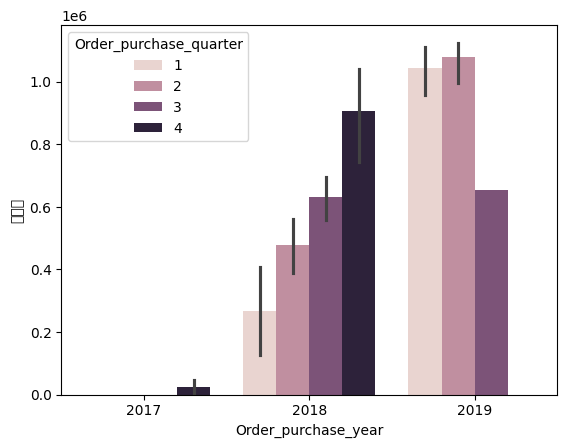

In [31]:
# 분기별 매출액 추이를 보기 위한 시각화 과정 : 하나의 그래프로 시각화
sns.barplot(월별_매출액, x="Order_purchase_year", y="매출액", hue="Order_purchase_quarter")

/home/hyun/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.draw()
/home/hyun/.local/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  fig.canvas.draw()
/home/hyun/.local/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Gl

/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  func(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  func(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  func(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:

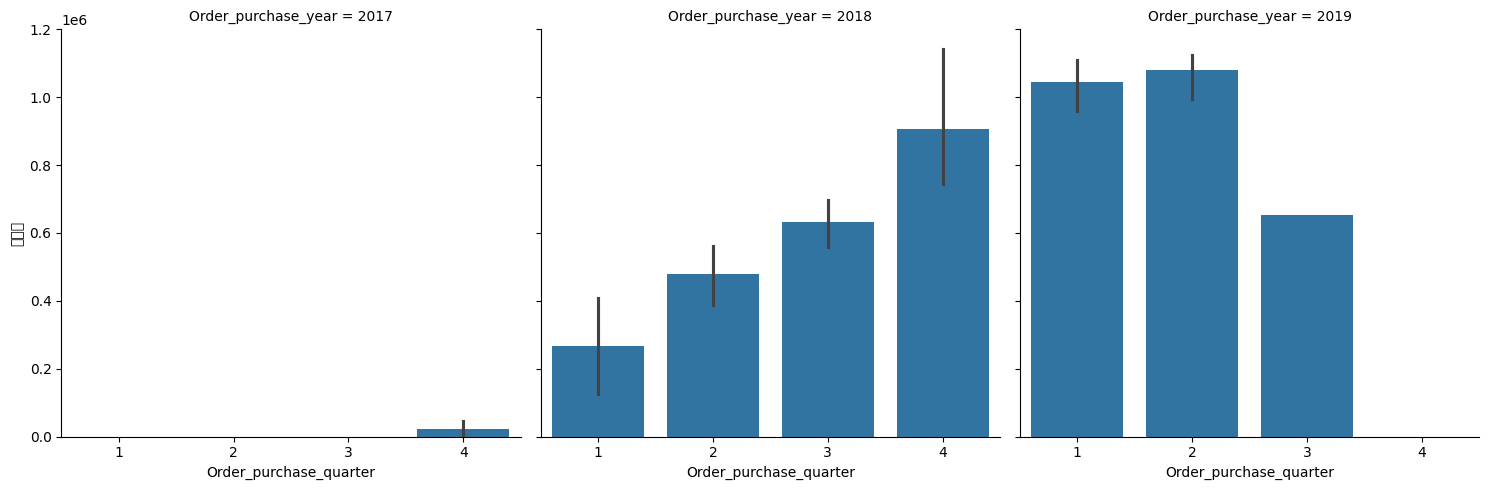

In [32]:
# 분기별 매출액 추이를 보기 위한 시각화 과정 : 연도별 1개씩 3개의 그래프로 시각화
sns.catplot( data=월별_매출액, x="Order_purchase_quarter", y="매출액", col="Order_purchase_year",kind="bar")

In [33]:
# 분기별 매출액을 보기 위해 분기별_매출액 정의
분기별_매출액 = 월별_매출액.groupby(['Order_purchase_year', 'Order_purchase_quarter'])[['매출액']].sum().reset_index()

분기별_매출액

,Order_purchase_year,Order_purchase_quarter,매출액
0,2017,4,45735.97
1,2018,1,801174.27
2,2018,2,1436311.89
3,2018,3,1893599.38
4,2018,4,2718376.49
5,2019,1,3135022.03
6,2019,2,3239050.65
7,2019,3,652168.01


In [34]:
# 전분기 대비 매출 성장률을 확인하기 위한 월별_매출액_증가율 컬럼 추가
# 매출 성장률(%) = (당기매출액 - 전기매출액) / 전기매출액 * 100
분기별_매출액_증가율 = []
for x in range(len(분기별_매출액)):
    if x == 0: 
        분기별_매출액_증가율.append(0)
    else:       
        분기별_매출액_증가율.append((분기별_매출액.iloc[x]['매출액'] - 분기별_매출액.iloc[x-1]['매출액']) / 분기별_매출액.iloc[x-1]['매출액'] * 100)

분기별_매출액['분기별_매출액_증가율'] = 분기별_매출액_증가율
분기별_매출액

,Order_purchase_year,Order_purchase_quarter,매출액,분기별_매출액_증가율
0,2017,4,45735.97,0.000000
1,2018,1,801174.27,1651.737790
2,2018,2,1436311.89,79.275838
3,2018,3,1893599.38,31.837618
4,2018,4,2718376.49,43.556051
5,2019,1,3135022.03,15.326999
6,2019,2,3239050.65,3.318274
7,2019,3,652168.01,-79.865458


In [35]:
# 월, 분기가 포함된 데이터 보존을 위해 복사본 사용
월_분기별_매출액 = 월별_매출액.copy()

월_분기별_매출액

,Order_purchase_year,Order_purchase_month,Order_purchase_quarter,매출액,월별_매출액_증가율
0,2017,10,4,45716.35,0.000000
1,2017,12,4,19.62,-99.957083
2,2018,1,1,125863.67,641406.982671
3,2018,2,1,267527.58,112.553456
4,2018,3,1,407783.02,52.426535
5,2018,4,2,388083.75,-4.830822
6,2018,5,2,561400.04,44.659507
7,2018,6,2,486828.10,-13.283209
8,2018,7,3,558946.88,14.814013
9,2018,8,3,638219.13,14.182430


In [36]:
# 분기별 매출액과 증가율 컬럼을 같이 볼 수 있도록 병합
월_분기별_매출액1 = 월별_매출액.merge(분기별_매출액, how='inner', on=['Order_purchase_year','Order_purchase_quarter'])
월_분기별_매출액1 = 월_분기별_매출액1.rename(columns={'매출액_x':'월별_매출액', '매출액_y':'분기별_매출액'})

월_분기별_매출액1

,Order_purchase_year,Order_purchase_month,Order_purchase_quarter,월별_매출액,월별_매출액_증가율,분기별_매출액,분기별_매출액_증가율
0,2017,10,4,45716.35,0.000000,45735.97,0.000000
1,2017,12,4,19.62,-99.957083,45735.97,0.000000
2,2018,1,1,125863.67,641406.982671,801174.27,1651.737790
3,2018,2,1,267527.58,112.553456,801174.27,1651.737790
4,2018,3,1,407783.02,52.426535,801174.27,1651.737790
5,2018,4,2,388083.75,-4.830822,1436311.89,79.275838
6,2018,5,2,561400.04,44.659507,1436311.89,79.275838
7,2018,6,2,486828.10,-13.283209,1436311.89,79.275838
8,2018,7,3,558946.88,14.814013,1893599.38,31.837618
9,2018,8,3,638219.13,14.182430,1893599.38,31.837618


데이터 전처리 과정을 통해 매출액이 점점 증가하는 추세를 보이다 2019년 하반기에 매출액이 감소되는 현황 파악  
매출액을 다시 올릴 수 있는 전략이 필요하다 판단

## 2. 효율적인 가격 선정을 위한 다중 평가 지표 분석

순서
- 통합 데이터 불러오기
- 필요 데이터 정제
- 소비자 구매 기준에 맞게 가중치 부여
- 가중치 적용
- KPI 도출

In [37]:
# 최종 정제 데이터 불러오기
with open('./dacon_total_df_20240504_01.pkl', 'rb') as f:
    dacon_total_df_20240503_02 = pickle.load(f)
# 원본 데이터 보존을 위해 복사본 사용
dacon_total_df_copy = dacon_total_df_20240503_02.copy()
dacon_total_df_copy

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter,순이익,매출액
355,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,20.58,CUSTOMER_06208,delivered,2017-10-05 07:31:49,2017-10-10 02:46:24,2017-10-16 14:36:00,2017-12-07,boleto,1,computers_accessories,CUSTOMER_Unique_06197,50090,recife,PE,30190,belo horizonte,MG,1,4,75.00,95.58
666,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,20.34,CUSTOMER_77212,delivered,2017-10-05 15:08:00,2017-10-10 15:44:27,2017-10-13 15:44:27,2017-11-29,credit_card,10,automotive,CUSTOMER_Unique_74990,13610,leme,SP,86035,londrina,PR,1,4,294.90,315.24
1321,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,17.61,CUSTOMER_36496,delivered,2017-10-04 14:13:22,2017-10-08 14:46:49,2017-10-11 14:46:49,2017-11-30,credit_card,4,furniture_decor,CUSTOMER_Unique_35969,21853,rio de janeiro,RJ,87900,loanda,PR,1,4,93.90,111.51
1385,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,15.63,CUSTOMER_15399,delivered,2017-10-07 00:54:40,2017-10-25 11:35:52,2017-10-27 17:32:07,2017-12-01,boleto,1,perfumery,CUSTOMER_Unique_15296,21220,rio de janeiro,RJ,17510,marilia,SP,3,4,134.70,181.59
2230,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,14.52,CUSTOMER_77880,delivered,2017-10-05 13:12:43,2017-10-21 16:34:58,2017-10-27 12:33:29,2017-11-29,credit_card,10,telephony,CUSTOMER_Unique_75617,37704,pocos de caldas,MG,2969,sao paulo,SP,2,4,79.80,108.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93368,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,15.27,CUSTOMER_61945,delivered,2019-07-06 11:18:39,2019-07-09 08:58:00,2019-07-12 17:48:52,2019-07-25,credit_card,1,furniture_decor,CUSTOMER_Unique_60513,2050,sao paulo,SP,20270,rio de janeiro,RJ,1,3,24.90,40.17
93392,ORDER_88004,PRODUCT_02102,SELLER_1628,2019,7,REVIEW_72610,5,2019-07-28,2019-07-29 02:33:56,70.00,13.32,CUSTOMER_52088,delivered,2019-07-24 21:58:04,2019-07-26 11:28:00,2019-07-27 23:03:17,2019-08-01,boleto,1,furniture_decor,CUSTOMER_Unique_51078,82860,curitiba,PR,80330,curitiba,PR,1,3,70.00,83.32
93409,ORDER_88021,PRODUCT_22041,SELLER_1230,2019,7,REVIEW_55262,5,2019-07-26,2019-07-26 22:20:21,40.99,14.60,CUSTOMER_19304,delivered,2019-07-21 01:01:06,2019-07-23 16:13:00,2019-07-25 17:37:40,2019-08-06,credit_card,5,home_utilities,CUSTOMER_Unique_19150,13515,charqueada,SP,3275,sao paulo,SP,1,3,40.99,55.59
93424,ORDER_88035,PRODUCT_02524,SELLER_1627,2019,7,REVIEW_32238,5,2019-07-25,2019-07-26 01:32:39,31.50,22.15,CUSTOMER_15679,delivered,2019-07-14 20:17:16,2019-07-16 09:03:00,2019-07-24 19:18:59,2019-08-08,credit_card,5,health_beauty,CUSTOMER_Unique_15573,48030,alagoinhas,BA,3006,sao paulo,SP,1,3,31.50,53.65


In [38]:
# locations 데이터의 중복되는 Geolocation_zipcode_prefix 값의 경우 좌표 평균값으로 위도 경도 지정
locations_group_lat = locations.groupby(["Geolocation_zipcode_prefix"])["Geolocation_lat"].mean().reset_index()
locations_group_lng = locations.groupby(["Geolocation_zipcode_prefix"])["Geolocation_lng"].mean().reset_index()
locations_group = pd.merge(locations_group_lat, locations_group_lng, how = 'inner', on="Geolocation_zipcode_prefix")

In [39]:
# 통합 데이터에 customer 위치 확인할 수 있도록 데이터프레임 통합
dacon_total_df_copy = pd.merge(dacon_total_df_copy, locations_group, left_on = 'Customer_zipcode_prefix', right_on = 'Geolocation_zipcode_prefix', how = 'inner')
# 컬럼명 변경
dacon_total_df_copy.rename(columns={'Geolocation_lat':'Customer_lat',"Geolocation_lng" : "Customer_lng" },inplace=True)
# 필요 없는 Geolocation_zipcode_prefix 컬럼 삭제
dacon_total_df_copy.drop(columns='Geolocation_zipcode_prefix',inplace=True)

In [40]:
# 통합 데이터에 seller 위치 확인할 수 있도록 데이터프레임 통합
dacon_total_df_copy = pd.merge(dacon_total_df_copy, locations_group, left_on = 'Seller_zipcode_prefix', right_on = 'Geolocation_zipcode_prefix', how = 'inner')
# 컬럼명 변경
dacon_total_df_copy.rename(columns={'Geolocation_lat':'Seller_lat',"Geolocation_lng" : "Seller_lng" },inplace=True)
# 필요 없는 Geolocation_zipcode_prefix 컬럼 삭제
dacon_total_df_copy.drop(columns='Geolocation_zipcode_prefix',inplace=True)

In [41]:
# customer와 seller와의 거리 계산 (Km 기준)
dist_list = []
for x in range(len(dacon_total_df_copy)):
    dist = haversine((dacon_total_df_copy.iloc[x]["Customer_lat"],dacon_total_df_copy.iloc[x]["Customer_lng"]),
                      (dacon_total_df_copy.iloc[x]["Seller_lat"], dacon_total_df_copy.iloc[x]["Seller_lng"]))
    dist_list.append(dist)

dist_list

[1638.8219501955803,
 403.92969326631714,
 988.3085672524976,
 685.667522185957,
 189.51597661113095,
 509.40276151204756,
 5.683517685548369,
 338.29862061376303,
 2143.0410913795117,
 517.7141874677953,
 774.9498590809399,
 23.779177559695018,
 2151.9271183549595,
 294.50085897955165,
 461.4584445779128,
 2.7957739051712256,
 84.08819717385904,
 43.289125802013906,
 194.28253491067747,
 202.24709975755908,
 1367.5328093376852,
 2204.7479180415426,
 13.451383838482455,
 132.5617904835518,
 99.84472925327822,
 2643.1710245834306,
 38.317094682112504,
 382.79934744657567,
 382.79934744657567,
 177.49333825592424,
 367.5508576134349,
 875.9980690074062,
 266.6467489741634,
 352.31527591281406,
 356.9580464484995,
 30.277941494377533,
 374.24337990915245,
 6.496228256383015,
 320.1326594498023,
 344.1965381293711,
 279.78673238799627,
 344.4742879173457,
 3.383878181597814,
 394.9379213832799,
 4.876382245483649,
 467.98793008239227,
 2357.427505381671,
 381.3478541463558,
 381.3478541463

In [43]:
# customer와 seller와의 거리 계산한 값 Distance 컬럼으로 추가
dacon_total_df_copy["Distance"] = dist_list

dacon_total_df_copy

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter,순이익,매출액,Customer_lat,Customer_lng,Seller_lat,Seller_lng,Distance
0,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,20.58,CUSTOMER_06208,delivered,2017-10-05 07:31:49,2017-10-10 02:46:24,2017-10-16 14:36:00,2017-12-07,boleto,1,computers_accessories,CUSTOMER_Unique_06197,50090,recife,PE,30190,belo horizonte,MG,1,4,75.00,95.58,-8.074551,-34.895035,-19.924640,-43.946122,1638.821950
1,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,20.34,CUSTOMER_77212,delivered,2017-10-05 15:08:00,2017-10-10 15:44:27,2017-10-13 15:44:27,2017-11-29,credit_card,10,automotive,CUSTOMER_Unique_74990,13610,leme,SP,86035,londrina,PR,1,4,294.90,315.24,-22.189204,-47.388202,-23.311083,-51.134917,403.929693
2,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,17.61,CUSTOMER_36496,delivered,2017-10-04 14:13:22,2017-10-08 14:46:49,2017-10-11 14:46:49,2017-11-30,credit_card,4,furniture_decor,CUSTOMER_Unique_35969,21853,rio de janeiro,RJ,87900,loanda,PR,1,4,93.90,111.51,-22.857083,-43.486439,-22.929384,-53.135873,988.308567
3,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,15.63,CUSTOMER_15399,delivered,2017-10-07 00:54:40,2017-10-25 11:35:52,2017-10-27 17:32:07,2017-12-01,boleto,1,perfumery,CUSTOMER_Unique_15296,21220,rio de janeiro,RJ,17510,marilia,SP,3,4,134.70,181.59,-22.849423,-43.313509,-22.197207,-49.952195,685.667522
4,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,14.52,CUSTOMER_77880,delivered,2017-10-05 13:12:43,2017-10-21 16:34:58,2017-10-27 12:33:29,2017-11-29,credit_card,10,telephony,CUSTOMER_Unique_75617,37704,pocos de caldas,MG,2969,sao paulo,SP,2,4,79.80,108.84,-21.792839,-46.567365,-23.492059,-46.710628,189.515977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90188,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,15.27,CUSTOMER_61945,delivered,2019-07-06 11:18:39,2019-07-09 08:58:00,2019-07-12 17:48:52,2019-07-25,credit_card,1,furniture_decor,CUSTOMER_Unique_60513,2050,sao paulo,SP,20270,rio de janeiro,RJ,1,3,24.90,40.17,-23.517344,-46.612135,-22.916245,-43.217950,353.224561
90189,ORDER_88004,PRODUCT_02102,SELLER_1628,2019,7,REVIEW_72610,5,2019-07-28,2019-07-29 02:33:56,70.00,13.32,CUSTOMER_52088,delivered,2019-07-24 21:58:04,2019-07-26 11:28:00,2019-07-27 23:03:17,2019-08-01,boleto,1,furniture_decor,CUSTOMER_Unique_51078,82860,curitiba,PR,80330,curitiba,PR,1,3,70.00,83.32,-25.384873,-49.197574,-25.469974,-49.307372,14.530102
90190,ORDER_88021,PRODUCT_22041,SELLER_1230,2019,7,REVIEW_55262,5,2019-07-26,2019-07-26 22:20:21,40.99,14.60,CUSTOMER_19304,delivered,2019-07-21 01:01:06,2019-07-23 16:13:00,2019-07-25 17:37:40,2019-08-06,credit_card,5,home_utilities,CUSTOMER_Unique_19150,13515,charqueada,SP,3275,sao paulo,SP,1,3,40.99,55.59,-22.511338,-47.775884,-23.583987,-46.541397,173.724008
90191,ORDER_88035,PRODUCT_02524,SELLER_1627,2019,7,REVIEW_32238,5,2019-07-25,2019-07-26 01:32:39,31.50,22.15,CUSTOMER_15679,delivered,2019-07-14 20:17:16,2019-07-16 09:03:00,2019-07-24 19:18:59,2019-08-08,credit_card,5,health_beauty,CUSTOMER_Unique_15573,48030,alagoinhas,BA,3006,sao paulo,SP,1,3,31.50,53.65,-12.137491,-38.405186,-23.541812,-46.624550,1536.749517


In [44]:
# 시간 계산을 위해 object -> datetime 로 데이터 타입 변경
dacon_total_df_copy['Order_purchase_timestamp']=pd.to_datetime(dacon_total_df_copy['Order_purchase_timestamp'])
dacon_total_df_copy['Order_delivered_carrier_date']=pd.to_datetime(dacon_total_df_copy['Order_delivered_carrier_date'])
dacon_total_df_copy['Order_delivered_customer_date']=pd.to_datetime(dacon_total_df_copy['Order_delivered_customer_date'])
dacon_total_df_copy['Order_estimated_delivery_date']=pd.to_datetime(dacon_total_df_copy['Order_estimated_delivery_date'])

In [45]:
# 주문 후 물류 처리까지 걸린 시간 확인을 위한 컬럼 추가
dacon_total_df_copy["time_diff_purchase_carrier"] = dacon_total_df_copy["Order_delivered_carrier_date"] - dacon_total_df_copy["Order_purchase_timestamp"]
# 주문 후 배송까지 걸린 시간 확인을 위한 컬럼 추가
dacon_total_df_copy["time_diff_purchase_customer"] = dacon_total_df_copy["Order_delivered_customer_date"] - dacon_total_df_copy["Order_purchase_timestamp"]
# 물류 처리 후 실제 배송까지 걸린 시간 확인을 위한 컬럼 추가
dacon_total_df_copy["time_diff_carrier_customer"] = dacon_total_df_copy["Order_delivered_customer_date"] - dacon_total_df_copy["Order_delivered_carrier_date"]
# 실제 배송일과 예상 배송일의 차이 확인을 위한 컬럼 추가
dacon_total_df_copy["time_diff_customer_delivery"] = dacon_total_df_copy['Order_estimated_delivery_date'] - dacon_total_df_copy["Order_delivered_customer_date"]

In [46]:
# 초 단위로 통일
dacon_total_df_copy["time_diff_purchase_carrier_second"] = dacon_total_df_copy["time_diff_purchase_carrier"].apply(lambda x : x.total_seconds())
dacon_total_df_copy["time_diff_purchase_customer_second"] = dacon_total_df_copy["time_diff_purchase_customer"].apply(lambda x : x.total_seconds())
dacon_total_df_copy["time_diff_carrier_customer_second"] = dacon_total_df_copy["time_diff_carrier_customer"].apply(lambda x : x.total_seconds())
dacon_total_df_copy["time_diff_customer_delivery_second"] = dacon_total_df_copy["time_diff_customer_delivery"].apply(lambda x : x.total_seconds())

In [47]:
# 월별로 분류하기 위한 컬럼 추가
dacon_total_df_copy['YearMonth'] = dacon_total_df_copy['Order_purchase_timestamp'].dt.strftime('%Y%m') #월별로 분류

In [48]:
# dacon_total_df_240504_00 데이터 pkl 로 저장
with open('./dacon_total_df_240504_00.pkl', 'wb') as f:
    pickle.dump(dacon_total_df_copy,f)

In [49]:
# 정제한 dacon_total_df_240504_00 의 상관계수 확인
dacon_total_df_copy.corr(numeric_only=True).style.background_gradient(cmap='coolwarm', axis=None)

,Order_purchase_year,Order_purchase_month,Review_score,Price,Freight_value,Payment_installments,Customer_zipcode_prefix,Seller_zipcode_prefix,order_count,Order_purchase_quarter,순이익,매출액,Customer_lat,Customer_lng,Seller_lat,Seller_lng,Distance,time_diff_purchase_carrier_second,time_diff_purchase_customer_second,time_diff_carrier_customer_second,time_diff_customer_delivery_second
Order_purchase_year,1.000000,-0.633579,-0.021666,-0.001304,0.026954,-0.057043,-0.034007,-0.010868,0.008005,-0.617778,-0.000584,0.001895,-0.024104,-0.010298,0.019746,0.009780,-0.036696,-0.083258,-0.020885,0.010659,-0.039261
Order_purchase_month,-0.633579,1.000000,0.024299,-0.000211,0.001748,0.037089,-0.000959,-0.015164,-0.003261,0.969899,0.000924,0.000900,0.008274,0.016411,-0.000773,0.000804,0.004365,0.035950,-0.033874,-0.051336,-0.013693
Review_score,-0.021666,0.024299,1.000000,-0.000670,-0.037136,-0.041016,-0.026468,0.024839,-0.084445,0.030925,-0.019222,-0.025070,-0.043951,-0.049495,-0.009685,0.017995,-0.061240,-0.146739,-0.323643,-0.293743,0.261153
Price,-0.001304,-0.000211,-0.000670,1.000000,0.414149,0.303817,0.041890,0.084121,-0.048304,-0.000747,0.939968,0.929968,0.054661,0.013928,0.020639,0.044435,0.082115,0.067602,0.060502,0.038790,0.004059
Freight_value,0.026954,0.001748,-0.037136,0.414149,1.000000,0.202655,0.226660,0.154694,-0.015956,-0.001505,0.394539,0.456822,0.274598,0.090615,0.035594,-0.009463,0.392277,0.090956,0.221030,0.204325,0.038303
Payment_installments,-0.057043,0.037089,-0.041016,0.303817,0.202655,1.000000,0.054158,0.040739,0.038776,0.034653,0.293668,0.298527,0.063610,0.037845,0.010955,-0.008750,0.087184,0.000715,0.048277,0.052314,0.029860
Customer_zipcode_prefix,-0.034007,-0.000959,-0.026468,0.041890,0.226660,0.054158,1.000000,0.071811,0.000193,-0.000555,0.040604,0.056951,0.118085,-0.311187,-0.013437,-0.017983,0.487339,0.009072,0.275057,0.296055,0.060322
Seller_zipcode_prefix,-0.010868,-0.015164,0.024839,0.084121,0.154694,0.040739,0.071811,1.000000,-0.011254,-0.014680,0.080948,0.088749,-0.035933,-0.034553,-0.148113,-0.431209,0.168650,0.006409,0.047138,0.048788,0.120891
order_count,0.008005,-0.003261,-0.084445,-0.048304,-0.015956,0.038776,0.000193,-0.011254,1.000000,-0.003225,0.139360,0.172146,-0.013460,-0.009875,-0.004821,-0.005454,-0.013161,0.042964,-0.007474,-0.025386,0.008476
Order_purchase_quarter,-0.617778,0.969899,0.030925,-0.000747,-0.001505,0.034653,-0.000555,-0.014680,-0.003225,1.000000,0.000439,0.000183,0.007850,0.015757,-0.002798,-0.002349,0.004053,0.038213,-0.047216,-0.066782,-0.005065


In [50]:
# 소비자가 물건을 구매하는 데 있어 고려하는 여러 가지 컬럼을 평가 지표의 변수로 지정하고, 이에 대해 가중치를 부여하는 과정
variable_importance = {
    # 'Payment_value': 1,
    'Review_score': 0.8,
    'Price': 0.6,
    'time_diff_customer_delivery_second': 0.5,
    'Distance': 0.4,
    'Freight_value': 0.3,
    'time_diff_purchase_customer_second': 0.2,
}

In [51]:
# 변수 가중치의 합 확인
total_importance = sum(variable_importance.values())

total_importance

2.8

In [53]:
# 변수의 가중치를 %로 계산한 것
normalized_importance = {key: value / total_importance for key, value in variable_importance.items()}

normalized_importance

{'Review_score': 0.28571428571428575,
 'Price': 0.2142857142857143,
 'time_diff_customer_delivery_second': 0.17857142857142858,
 'Distance': 0.14285714285714288,
 'Freight_value': 0.10714285714285715,
 'time_diff_purchase_customer_second': 0.07142857142857144}

In [59]:
# 가중치 계산을 위한 정제 과정 1 : 정제된 전체 데이터에서 order_count 와 Product_id 를 그룹으로 묶어 숫자를 센 컬럼 추가
head = dacon_total_df_copy.groupby(['Order_id', 'Product_id', 'Seller_id', 'Order_purchase_year', 'Order_purchase_month', 'Review_id', 'Seller_zipcode_prefix']).value_counts().reset_index().sort_values(['order_count','Product_id'], ascending=[False, True])

head

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Seller_zipcode_prefix,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_city,Seller_state,order_count,Order_purchase_quarter,순이익,매출액,Customer_lat,Customer_lng,Seller_lat,Seller_lng,Distance,time_diff_purchase_carrier,time_diff_purchase_customer,time_diff_carrier_customer,time_diff_customer_delivery,time_diff_purchase_carrier_second,time_diff_purchase_customer_second,time_diff_carrier_customer_second,time_diff_customer_delivery_second,YearMonth,count
78812,ORDER_77030,PRODUCT_24966,SELLER_0262,2019,2,REVIEW_51671,12233,1,2019-03-06,2019-03-12 12:46:07,100.00,10.12,CUSTOMER_15677,delivered,2019-02-22 15:30:41,2019-03-02 00:18:01,2019-03-05 15:22:27,2019-03-08,boleto,1,computers_accessories,CUSTOMER_Unique_15571,3029,sao paulo,SP,sao jose dos campos,SP,20,1,2000.00,2202.40,-23.529825,-46.618174,-23.246681,-45.886909,81.001002,7 days 08:47:20,10 days 23:51:46,3 days 15:04:26,2 days 08:37:33,636440.0,949906.0,313466.0,203853.0,201902,1
60177,ORDER_58777,PRODUCT_14642,SELLER_2683,2018,1,REVIEW_58723,89255,5,2018-02-15,2018-02-16 17:14:41,51.00,1.20,CUSTOMER_06205,delivered,2018-01-30 21:44:49,2018-02-01 14:34:10,2018-02-14 10:48:10,2018-03-07,credit_card,10,garden_tools,CUSTOMER_Unique_06194,74885,goiania,GO,jaragua do sul,SC,15,1,765.00,783.00,-16.697834,-49.247263,-26.467360,-49.093062,1086.439837,1 days 16:49:21,14 days 13:03:21,12 days 20:14:00,20 days 13:11:50,146961.0,1256601.0,1109640.0,1775510.0,201801,1
27461,ORDER_26840,PRODUCT_18605,SELLER_0406,2018,11,REVIEW_82455,15601,5,2018-12-14,2018-12-19 14:14:16,65.49,16.22,CUSTOMER_69415,delivered,2018-11-23 20:30:52,2018-11-28 16:42:21,2018-12-13 20:19:35,2018-12-19,credit_card,10,furniture_decor,CUSTOMER_Unique_27856,84600,uniao da vitoria,PR,fernandopolis,SP,15,4,982.35,1225.65,-26.230550,-51.085926,-20.293309,-50.256318,665.601956,4 days 20:11:29,19 days 23:48:43,15 days 03:37:14,5 days 03:40:25,418289.0,1727323.0,1309034.0,445225.0,201811,1
25031,ORDER_24482,PRODUCT_04327,SELLER_1050,2019,2,REVIEW_38838,9291,1,2019-03-02,2019-03-03 00:44:54,29.99,7.78,CUSTOMER_71637,delivered,2019-02-21 11:45:07,2019-02-27 18:27:01,2019-03-01 20:47:01,2019-03-07,credit_card,6,telephony,CUSTOMER_Unique_69715,13330,indaiatuba,SP,santo andre,SP,14,1,419.86,528.78,-23.086339,-47.216887,-23.645101,-46.519201,94.509992,6 days 06:41:54,8 days 09:01:54,2 days 02:20:00,5 days 03:12:59,542514.0,723714.0,181200.0,443579.0,201902,1
24795,ORDER_24250,PRODUCT_12522,SELLER_0417,2018,12,REVIEW_84898,15025,1,2018-12-29,2018-12-31 12:08:24,59.00,13.43,CUSTOMER_50177,delivered,2018-12-13 14:21:15,2018-12-15 18:45:18,2018-12-28 09:05:34,2019-01-08,boleto,1,garden_tools,CUSTOMER_Unique_49239,11065,santos,SP,sao jose do rio preto,SP,14,4,826.00,1014.02,-23.965227,-46.343581,-20.806707,-49.389165,470.490242,2 days 04:24:03,14 days 18:44:19,12 days 14:20:16,10 days 14:54:26,188643.0,1277059.0,1088416.0,917666.0,201812,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34086,ORDER_33298,PRODUCT_29468,SELLER_0768,2019,2,REVIEW_86976,19470,4,2019-03-16,2019-03-19 01:04:29,127.00,34.69,CUSTOMER_13708,delivered,2019-02-12 00:27:57,2019-02-15 17:45:52,2019-03-15 21:12:32,2019-03-15,credit_card,2,bed_bath_table,CUSTOMER_Unique_13626,65910,imperatriz,MA,presidente epitacio,SP,1,1,127.00,161.69,-5.516372,-47.476872,-21.773563,-52.115710,1875.396881,3 days 17:17:55,31 days 20:44:35,28 days 03:26:40,-1 days +02:47:28,321475.0,2753075.0,2431600.0,-76352.0,201902,1
38663,ORDER_37778,PRODUCT_29468,SELLER_0768,2019,1

In [60]:
# 가중치 계산을 위한 정제 과정 : head 데이터에서 필요한 컬럼만 추출
head2 = head.drop(columns=['Order_id', 'Seller_id', 'Review_id', 'Customer_id', 'Order_status', 'Payment_type', 'Payment_installments', 'Product_category_name', 'Customer_unique_id', 'Customer_zipcode_prefix', 'Customer_city', 'Customer_state', 'Seller_zipcode_prefix', 'Seller_city', 'Seller_state', 'order_count', 'Seller_lat', 'Seller_lng', 'Customer_lat', 'Customer_lng', 'Review_creation_date', 'Review_answer_timestamp', 'Order_purchase_timestamp', 'Order_delivered_carrier_date', 'Order_delivered_customer_date', 'Order_estimated_delivery_date', 'time_diff_purchase_carrier', 'time_diff_purchase_customer', 'time_diff_carrier_customer', 'time_diff_customer_delivery'])

head2

,Product_id,Order_purchase_year,Order_purchase_month,Review_score,Price,Freight_value,Order_purchase_quarter,순이익,매출액,Distance,time_diff_purchase_carrier_second,time_diff_purchase_customer_second,time_diff_carrier_customer_second,time_diff_customer_delivery_second,YearMonth,count
78812,PRODUCT_24966,2019,2,1,100.00,10.12,1,2000.00,2202.40,81.001002,636440.0,949906.0,313466.0,203853.0,201902,1
60177,PRODUCT_14642,2018,1,5,51.00,1.20,1,765.00,783.00,1086.439837,146961.0,1256601.0,1109640.0,1775510.0,201801,1
27461,PRODUCT_18605,2018,11,5,65.49,16.22,4,982.35,1225.65,665.601956,418289.0,1727323.0,1309034.0,445225.0,201811,1
25031,PRODUCT_04327,2019,2,1,29.99,7.78,1,419.86,528.78,94.509992,542514.0,723714.0,181200.0,443579.0,201902,1
24795,PRODUCT_12522,2018,12,1,59.00,13.43,4,826.00,1014.02,470.490242,188643.0,1277059.0,1088416.0,917666.0,201812,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34086,PRODUCT_29468,2019,2,4,127.00,34.69,1,127.00,161.69,1875.396881,321475.0,2753075.0,2431600.0,-76352.0,201902,1
38663,PRODUCT_29468,2019,1,5,127.00,12.39,1,127.00,139.39,647.940361,74103.0,1129132.0,1055029.0,608472.0,201901,1
41344,PRODUCT_29468,2018,8,5,127.50,17.14,3,127.50,144.64,308.883363,85064.0,786643.0,701579.0,1144294.0,201808,1
45985,PRODUCT_29468,2019,6,4,127.50,11.91,2,127.50,139.41,20.875922,153737.0,434148.0,280411.0,1070669.0,201906,1


In [61]:
# 불필요한 count 컬럼 삭제
head2.drop(columns='count',inplace=True)

In [63]:
# 가중치 작업을 위해 유일한 Product_id 값 추출
dacon_last_id = dacon_total_df_copy['Product_id'].unique()
len(dacon_last_id)

29196

In [64]:
# 원본 데이터 보존을 위해 복사본 사용
dacon_remake_df = dacon_total_df_copy.copy()

In [65]:
# 가중치 함수
i = 0
for product_id in tqdm(dacon_last_id): # dacon_total_df_copy['Product_id'].unique()
    test_df = head2[head2['Product_id'] == product_id]
    test_df = test_df.drop(["Product_id"],axis=1) # 불필요한 데이터 drop

    scaler = StandardScaler()

    #독립 변수를 평균이 0이고 표준편차가 1인 분포로 변환, fit_transform은 데이터의 평균과 표준편차 계산
    X_standardized = scaler.fit_transform(test_df) 
    
    #윗줄에서 계산한 numpy배열과 컬럼명은 test_df를 따라서 df생성
    X_standardized_df = pd.DataFrame(X_standardized, columns=test_df.columns) 
    
    #위에서 선언한 키를 column에 값(가중치)를 weight에 할당
    for column, weight in normalized_importance.items(): 
        #각 독립변수에 가중치 계산
        X_standardized_df[column] *= weight
    
    # y값 도출
    weighted_sum = X_standardized_df.sum(axis=1)
    weighted_sum_max=weighted_sum.max()
    max_index = weighted_sum.idxmax()
    
    #가중합이 가장 큰 값을 갖는 행에 해당하는 매출액을 찾아서 값 저장
    max_payment_value=test_df.iloc[max_index]["매출액"]
    
    # product_id가 일치하는 행을 찾아서 매출액 값 저장
    dacon_remake_df.loc[dacon_remake_df["Product_id"]==product_id , "매출액"] = max_payment_value
    
    i += 1
    

100%|██████████| 29196/29196 [06:50<00:00, 71.15it/s]


In [67]:
# Product_id 중복 데이터 확인
dacon_total_df_copy[dacon_total_df_copy.Product_id.duplicated()]

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter,순이익,매출액,Customer_lat,Customer_lng,Seller_lat,Seller_lng,Distance,time_diff_purchase_carrier,time_diff_purchase_customer,time_diff_carrier_customer,time_diff_customer_delivery,time_diff_purchase_carrier_second,time_diff_purchase_customer_second,time_diff_carrier_customer_second,time_diff_customer_delivery_second,YearMonth
62,ORDER_19141,PRODUCT_01434,SELLER_1696,2017,10,REVIEW_45288,5,2017-11-05,2017-11-07 11:50:28,249.90,23.87,CUSTOMER_65561,delivered,2017-10-05 12:34:04,2017-10-30 15:24:49,2017-11-04 14:31:26,2017-12-07,credit_card,10,perfumery,CUSTOMER_Unique_63960,52091,recife,PE,25645,petropolis,RJ,1,4,249.90,273.77,-8.004623,-34.934960,-22.540797,-43.201235,1842.165076,25 days 02:50:45,30 days 01:57:22,4 days 23:06:37,32 days 09:28:34,2170245.0,2599042.0,428797.0,2798914.0,201710
68,ORDER_21909,PRODUCT_01434,SELLER_1696,2017,10,REVIEW_87178,3,2017-10-26,2017-10-27 23:05:25,249.90,17.59,CUSTOMER_52450,delivered,2017-10-04 13:15:46,2017-10-10 16:45:50,2017-10-17 11:25:59,2017-11-28,credit_card,10,perfumery,CUSTOMER_Unique_51428,31210,belo horizonte,MG,25645,petropolis,RJ,1,4,249.90,267.49,-19.906712,-43.948897,-22.540797,-43.201235,302.973741,6 days 03:30:04,12 days 22:10:13,6 days 18:40:09,41 days 12:34:01,531004.0,1116613.0,585609.0,3587641.0,201710
101,ORDER_31750,PRODUCT_09474,SELLER_1696,2017,10,REVIEW_43488,5,2017-10-25,2017-10-26 01:30:00,59.90,25.18,CUSTOMER_36379,delivered,2017-10-08 22:34:11,2017-10-14 18:00:00,2017-10-15 05:02:06,2017-12-12,boleto,1,perfumery,CUSTOMER_Unique_35855,62050,sobral,CE,25645,petropolis,RJ,1,4,59.90,85.08,-3.701345,-40.336394,-22.540797,-43.201235,2117.463295,5 days 19:25:49,6 days 06:27:55,0 days 11:02:06,57 days 18:57:54,501949.0,541675.0,39726.0,4993074.0,201710
105,ORDER_33077,PRODUCT_20195,SELLER_1696,2017,10,REVIEW_32198,5,2017-10-21,2017-10-22 04:09:29,339.90,21.27,CUSTOMER_78812,delivered,2017-10-08 11:50:02,2017-10-12 13:22:13,2017-10-15 13:22:13,2017-12-06,credit_card,10,perfumery,CUSTOMER_Unique_76503,74845,goiania,GO,25645,petropolis,RJ,1,4,339.90,361.17,-16.717347,-49.242839,-22.540797,-43.201235,905.079613,4 days 01:32:11,7 days 01:32:11,3 days 00:00:00,51 days 10:37:47,351131.0,610331.0,259200.0,4444667.0,201710
107,ORDER_34318,PRODUCT_03334,SELLER_1546,2017,10,REVIEW_38486,3,2017-11-25,2017-11-26 21:22:37,59.90,17.70,CUSTOMER_05943,delivered,2017-10-10 11:39:06,2017-11-14 12:38:44,2017-11-24 14:55:43,2017-12-08,credit_card,5,health_beauty,CUSTOMER_Unique_05933,71925,brasilia,DF,81810,curitiba,PR,2,4,119.80,155.20,-15.843049,-48.008410,-25.507014,-49.275963,1082.619121,35 days 00:59:38,45 days 03:16:37,10 days 02:16:59,13 days 09:04:17,3027578.0,3899797.0,872219.0,1155857.0,201710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90188,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,15.27,CUSTOMER_61945,delivered,2019-07-06 11:18:39,2019-07-09 08:58:00,2019-07-12 17:48:52,2019-07-25,credit_card,1,furniture_decor,CUSTOMER_Unique_60513,2050,sao paulo,SP,20270,rio de janeiro,RJ,1,3,24.90,40.17,-23.517344,-46.612135,-22.916245,-43.217950,353.224561,2 days 21:39:21,6 days 06:30:13,3 days 08:50:52,12 days 06:11:08,250761.0,541813.0,291052.0,1059068.0,201907
90189,ORDER_88004,PRODUCT_02102,SELLER_1628,2019,7,REVIEW_72610,5,2019-07-28,2019-07-29 02:33:56,70.00,13.32,CUSTOMER_52088,delivered,2019-07-24

In [94]:
# 가중치 적용 비교를 위한 기존 데이터에서 임시 데이터 추출
head5_1 = dacon_total_df_copy[dacon_total_df_copy.Product_id=="PRODUCT_27073"].sort_values('순이익', ascending=False)

In [95]:
# 기존 데이터 추출
head5_1[['Product_id','Seller_id','순이익','매출액']]

,Product_id,Seller_id,순이익,매출액
79574,PRODUCT_27073,SELLER_1380,296.0,324.98
68277,PRODUCT_27073,SELLER_1380,189.0,202.98
77066,PRODUCT_27073,SELLER_1380,154.0,163.43
82084,PRODUCT_27073,SELLER_1380,154.0,174.05
83459,PRODUCT_27073,SELLER_0891,149.0,161.27
84285,PRODUCT_27073,SELLER_0891,149.0,157.81
71848,PRODUCT_27073,SELLER_0891,149.0,157.81
79340,PRODUCT_27073,SELLER_0891,149.0,157.81
85275,PRODUCT_27073,SELLER_0891,149.0,163.49
68203,PRODUCT_27073,SELLER_0891,144.0,157.45


In [96]:
# 가중치 적용 비교를 위한 가중치 적용 데이터에서 임시 데이터 추출
head5_2 = dacon_remake_df[dacon_remake_df.Product_id=="PRODUCT_27073"].sort_values('순이익', ascending=False)

In [97]:
# 가중치가 적용된 데이터 추출
# 판매 효율이 좋은 매출액으로 바뀐 것을 확인할 수 있음
head5_2[['Product_id','Seller_id','순이익','매출액']]

,Product_id,Seller_id,순이익,매출액
79574,PRODUCT_27073,SELLER_1380,296.0,324.98
68277,PRODUCT_27073,SELLER_1380,189.0,324.98
77066,PRODUCT_27073,SELLER_1380,154.0,324.98
82084,PRODUCT_27073,SELLER_1380,154.0,324.98
83459,PRODUCT_27073,SELLER_0891,149.0,324.98
84285,PRODUCT_27073,SELLER_0891,149.0,324.98
71848,PRODUCT_27073,SELLER_0891,149.0,324.98
79340,PRODUCT_27073,SELLER_0891,149.0,324.98
85275,PRODUCT_27073,SELLER_0891,149.0,324.98
68203,PRODUCT_27073,SELLER_0891,144.0,324.98


In [98]:
# 기존 데이터의 총 매출액
dacon_total_df_copy.매출액.sum()

13854366.929999998

In [99]:
# 가중치가 적용된 데이터의 총 매출액
dacon_remake_df.매출액.sum() 

19804085.93

In [100]:
# 두 매출액의 차이
dacon_remake_df.매출액.sum()  - dacon_total_df_copy.매출액.sum()

5949719.000000002

### KPI 1
가중치를 적용하여 분석 했을 때 가장 긍정적인 값이 나오는 payment_value 와 유사한 값으로 소비자가 제품을 구매할 수 있도록 유도하자

## 3. 기존 재구매 고객의 구매 주기 분석으로 이상적인 재구매 주기 분석

순서
- 통합 데이터 불러오기
- 재구매 여부, 구매 일수를 확인하기 위한 컬럼 추가
- 재구매 경험이 없는 소비자 데이터와 재구매 경험이 있는 소비자 데이터 각각 추출
- 재구매 경험이 없는 데이터의 임의의 10% 호출하는 데이터 추출
- 재구매 경험이 있는 구매자의 재구매 주기별 데이터 추출
- 가장 효율적이었던 구매 기간에 재구매 경험이 없는 소비자 데이터의 임의 값을 부여하여 예상 매출액 및 상관계수 확인
- KPI 도출

In [2]:
# 피클 import
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 통합 데이터 불러오기
with open('./dacon_total_df_240504_00.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
# 주문일 비교를 위한 날짜 컬럼 추가
df['day'] = df.Order_purchase_timestamp.dt.day
df['YearMonthDay'] = df['Order_purchase_timestamp'].dt.strftime('%Y%m%d')

df

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,...,time_diff_purchase_customer,time_diff_carrier_customer,time_diff_customer_delivery,time_diff_purchase_carrier_second,time_diff_purchase_customer_second,time_diff_carrier_customer_second,time_diff_customer_delivery_second,YearMonth,day,YearMonthDay
0,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,...,11 days 07:04:11,6 days 11:49:36,51 days 09:24:00,414875.0,975851.0,560976.0,4440240.0,201710,5,20171005
1,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,...,8 days 00:36:27,3 days 00:00:00,46 days 08:15:33,434187.0,693387.0,259200.0,4004133.0,201710,5,20171005
2,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,...,7 days 00:33:27,3 days 00:00:00,49 days 09:13:11,347607.0,606807.0,259200.0,4266791.0,201710,4,20171004
3,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,...,20 days 16:37:27,2 days 05:56:15,34 days 06:27:53,1593672.0,1787847.0,194175.0,2960873.0,201710,7,20171007
4,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,...,21 days 23:20:46,5 days 19:58:31,32 days 11:26:31,1394535.0,1898446.0,503911.0,2805991.0,201710,5,20171005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90188,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,...,6 days 06:30:13,3 days 08:50:52,12 days 06:11:08,250761.0,541813.0,291052.0,1059068.0,201907,6,20190706
90189,ORDER_88004,PRODUCT_02102,SELLER_1628,2019,7,REVIEW_72610,5,2019-07-28,2019-07-29 02:33:56,70.00,...,3 days 01:05:13,1 days 11:35:17,4 days 00:56:43,134996.0,263113.0,128117.0,349003.0,201907,24,20190724
90190,ORDER_88021,PRODUCT_22041,SELLER_1230,2019,7,REVIEW_55262,5,2019-07-26,2019-07-26 22:20:21,40.99,...,4 days 16:36:34,2 days 01:24:40,11 days 06:22:20,227514.0,405394.0,177880.0,973340.0,201907,21,20190721
90191,ORDER_88035,PRODUCT_02524,SELLER_1627,2019,7,REVIEW_32238,5,2019-07-25,2019-07-26 01:32:39,31.50,...,9 days 23:01:43,8 days 10:15:59,14 days 04:41:01,132344.0,860503.0,728159.0,1226461.0,201907,14,20190714


In [5]:
# 원본 데이터 보존을 위해 복사본 사용
df_copy = df.copy()

df_copy

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,...,time_diff_purchase_customer,time_diff_carrier_customer,time_diff_customer_delivery,time_diff_purchase_carrier_second,time_diff_purchase_customer_second,time_diff_carrier_customer_second,time_diff_customer_delivery_second,YearMonth,day,YearMonthDay
0,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,...,11 days 07:04:11,6 days 11:49:36,51 days 09:24:00,414875.0,975851.0,560976.0,4440240.0,201710,5,20171005
1,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,...,8 days 00:36:27,3 days 00:00:00,46 days 08:15:33,434187.0,693387.0,259200.0,4004133.0,201710,5,20171005
2,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,...,7 days 00:33:27,3 days 00:00:00,49 days 09:13:11,347607.0,606807.0,259200.0,4266791.0,201710,4,20171004
3,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,...,20 days 16:37:27,2 days 05:56:15,34 days 06:27:53,1593672.0,1787847.0,194175.0,2960873.0,201710,7,20171007
4,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,...,21 days 23:20:46,5 days 19:58:31,32 days 11:26:31,1394535.0,1898446.0,503911.0,2805991.0,201710,5,20171005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90188,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,...,6 days 06:30:13,3 days 08:50:52,12 days 06:11:08,250761.0,541813.0,291052.0,1059068.0,201907,6,20190706
90189,ORDER_88004,PRODUCT_02102,SELLER_1628,2019,7,REVIEW_72610,5,2019-07-28,2019-07-29 02:33:56,70.00,...,3 days 01:05:13,1 days 11:35:17,4 days 00:56:43,134996.0,263113.0,128117.0,349003.0,201907,24,20190724
90190,ORDER_88021,PRODUCT_22041,SELLER_1230,2019,7,REVIEW_55262,5,2019-07-26,2019-07-26 22:20:21,40.99,...,4 days 16:36:34,2 days 01:24:40,11 days 06:22:20,227514.0,405394.0,177880.0,973340.0,201907,21,20190721
90191,ORDER_88035,PRODUCT_02524,SELLER_1627,2019,7,REVIEW_32238,5,2019-07-25,2019-07-26 01:32:39,31.50,...,9 days 23:01:43,8 days 10:15:59,14 days 04:41:01,132344.0,860503.0,728159.0,1226461.0,201907,14,20190714


In [5]:
# 유니크한 구매 일수를 구하기 위해 필요한 컬럼 추출
df_copy2 = df_copy[['YearMonthDay', 'Customer_unique_id']]

df_copy2

,YearMonthDay,Customer_unique_id
0,20171005,CUSTOMER_Unique_06197
1,20171005,CUSTOMER_Unique_74990
2,20171004,CUSTOMER_Unique_35969
3,20171007,CUSTOMER_Unique_15296
4,20171005,CUSTOMER_Unique_75617
...,...,...
90188,20190706,CUSTOMER_Unique_60513
90189,20190724,CUSTOMER_Unique_51078
90190,20190721,CUSTOMER_Unique_19150
90191,20190714,CUSTOMER_Unique_15573


In [6]:
# 중복 row 삭제
# Customer_unique_id 가 주문 했던 날짜만 볼 수 있음
df_copy3 = df_copy2.drop_duplicates(subset=['YearMonthDay', 'Customer_unique_id'])

df_copy3

,YearMonthDay,Customer_unique_id
0,20171005,CUSTOMER_Unique_06197
1,20171005,CUSTOMER_Unique_74990
2,20171004,CUSTOMER_Unique_35969
3,20171007,CUSTOMER_Unique_15296
4,20171005,CUSTOMER_Unique_75617
...,...,...
90188,20190706,CUSTOMER_Unique_60513
90189,20190724,CUSTOMER_Unique_51078
90190,20190721,CUSTOMER_Unique_19150
90191,20190714,CUSTOMER_Unique_15573


In [7]:
# Customer_unique_id 의 갯수를 센 컬럼 추가
# 구매했던 날짜의 수를 의미
# 구매일수가 1인 경우에는 재구매를 하지 않은 사람 2 이상의 경우 재구매를 한 사람
df_copy4 = df_copy3.groupby(by='Customer_unique_id')['Customer_unique_id'].value_counts().reset_index()
# 컬럼 이해를 위해 컬럼명 변경
df_copy4.rename(columns={'count':'구매일수'},inplace=True)

df_copy4

,Customer_unique_id,구매일수
0,CUSTOMER_Unique_00000,1
1,CUSTOMER_Unique_00001,1
2,CUSTOMER_Unique_00002,1
3,CUSTOMER_Unique_00003,1
4,CUSTOMER_Unique_00004,2
...,...,...
84125,CUSTOMER_Unique_85234,1
84126,CUSTOMER_Unique_85235,1
84127,CUSTOMER_Unique_85236,1
84128,CUSTOMER_Unique_85237,1


In [8]:
# 정제 데이터에 구매일수 컬럼 추가
df_copy5 = pd.merge(df_copy, df_copy4, on='Customer_unique_id', how='inner')
df_copy5

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter,순이익,매출액,Customer_lat,Customer_lng,Seller_lat,Seller_lng,Distance,time_diff_purchase_carrier,time_diff_purchase_customer,time_diff_carrier_customer,time_diff_customer_delivery,time_diff_purchase_carrier_second,time_diff_purchase_customer_second,time_diff_carrier_customer_second,time_diff_customer_delivery_second,YearMonth,day,YearMonthDay,구매일수
0,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,20.58,CUSTOMER_06208,delivered,2017-10-05 07:31:49,2017-10-10 02:46:24,2017-10-16 14:36:00,2017-12-07,boleto,1,computers_accessories,CUSTOMER_Unique_06197,50090,recife,PE,30190,belo horizonte,MG,1,4,75.00,95.58,-8.074551,-34.895035,-19.924640,-43.946122,1638.821950,4 days 19:14:35,11 days 07:04:11,6 days 11:49:36,51 days 09:24:00,414875.0,975851.0,560976.0,4440240.0,201710,5,20171005,1
1,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,20.34,CUSTOMER_77212,delivered,2017-10-05 15:08:00,2017-10-10 15:44:27,2017-10-13 15:44:27,2017-11-29,credit_card,10,automotive,CUSTOMER_Unique_74990,13610,leme,SP,86035,londrina,PR,1,4,294.90,315.24,-22.189204,-47.388202,-23.311083,-51.134917,403.929693,5 days 00:36:27,8 days 00:36:27,3 days 00:00:00,46 days 08:15:33,434187.0,693387.0,259200.0,4004133.0,201710,5,20171005,1
2,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,17.61,CUSTOMER_36496,delivered,2017-10-04 14:13:22,2017-10-08 14:46:49,2017-10-11 14:46:49,2017-11-30,credit_card,4,furniture_decor,CUSTOMER_Unique_35969,21853,rio de janeiro,RJ,87900,loanda,PR,1,4,93.90,111.51,-22.857083,-43.486439,-22.929384,-53.135873,988.308567,4 days 00:33:27,7 days 00:33:27,3 days 00:00:00,49 days 09:13:11,347607.0,606807.0,259200.0,4266791.0,201710,4,20171004,1
3,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,15.63,CUSTOMER_15399,delivered,2017-10-07 00:54:40,2017-10-25 11:35:52,2017-10-27 17:32:07,2017-12-01,boleto,1,perfumery,CUSTOMER_Unique_15296,21220,rio de janeiro,RJ,17510,marilia,SP,3,4,134.70,181.59,-22.849423,-43.313509,-22.197207,-49.952195,685.667522,18 days 10:41:12,20 days 16:37:27,2 days 05:56:15,34 days 06:27:53,1593672.0,1787847.0,194175.0,2960873.0,201710,7,20171007,1
4,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,14.52,CUSTOMER_77880,delivered,2017-10-05 13:12:43,2017-10-21 16:34:58,2017-10-27 12:33:29,2017-11-29,credit_card,10,telephony,CUSTOMER_Unique_75617,37704,pocos de caldas,MG,2969,sao paulo,SP,2,4,79.80,108.84,-21.792839,-46.567365,-23.492059,-46.710628,189.515977,16 days 03:22:15,21 days 23:20:46,5 days 19:58:31,32 days 11:26:31,1394535.0,1898446.0,503911.0,2805991.0,201710,5,20171005,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90188,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,15.27,CUSTOMER_61945,delivered,2019-07-06 11:18:39,2019-07-09 08:58:00,2019-07-12 17:48:52,2019-07-25,credit_card,1,furniture_decor,CUSTOMER_Unique_60513,2050,sao paulo,SP,20270,rio de janeiro,RJ,1,3,24.90,40.17,-23.517344,-46.612135,-22.916245,-43.217950,353.224561,2 days 21:39:21,6 days 06:30:13,3 days 08:50:52,12 days 06:11:08,250761.0,541813.0,291052.0,1059068.0,201907,6,20190706,1
90189,ORDER_88004,PRODUCT_0210

In [9]:
# df_copy5 데이터 pkl 로 저장
with open('./dacon_total_df_240505_01.pkl', 'wb') as f:
    pickle.dump(df_copy5, f)

In [10]:
# 저장한 데이터 불러오기
with open ("./dacon_total_df_240505_01.pkl", "rb") as file:
    last_df = pickle.load(file)

last_df

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter,순이익,매출액,Customer_lat,Customer_lng,Seller_lat,Seller_lng,Distance,time_diff_purchase_carrier,time_diff_purchase_customer,time_diff_carrier_customer,time_diff_customer_delivery,time_diff_purchase_carrier_second,time_diff_purchase_customer_second,time_diff_carrier_customer_second,time_diff_customer_delivery_second,YearMonth,day,YearMonthDay,구매일수
0,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,20.58,CUSTOMER_06208,delivered,2017-10-05 07:31:49,2017-10-10 02:46:24,2017-10-16 14:36:00,2017-12-07,boleto,1,computers_accessories,CUSTOMER_Unique_06197,50090,recife,PE,30190,belo horizonte,MG,1,4,75.00,95.58,-8.074551,-34.895035,-19.924640,-43.946122,1638.821950,4 days 19:14:35,11 days 07:04:11,6 days 11:49:36,51 days 09:24:00,414875.0,975851.0,560976.0,4440240.0,201710,5,20171005,1
1,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,20.34,CUSTOMER_77212,delivered,2017-10-05 15:08:00,2017-10-10 15:44:27,2017-10-13 15:44:27,2017-11-29,credit_card,10,automotive,CUSTOMER_Unique_74990,13610,leme,SP,86035,londrina,PR,1,4,294.90,315.24,-22.189204,-47.388202,-23.311083,-51.134917,403.929693,5 days 00:36:27,8 days 00:36:27,3 days 00:00:00,46 days 08:15:33,434187.0,693387.0,259200.0,4004133.0,201710,5,20171005,1
2,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,17.61,CUSTOMER_36496,delivered,2017-10-04 14:13:22,2017-10-08 14:46:49,2017-10-11 14:46:49,2017-11-30,credit_card,4,furniture_decor,CUSTOMER_Unique_35969,21853,rio de janeiro,RJ,87900,loanda,PR,1,4,93.90,111.51,-22.857083,-43.486439,-22.929384,-53.135873,988.308567,4 days 00:33:27,7 days 00:33:27,3 days 00:00:00,49 days 09:13:11,347607.0,606807.0,259200.0,4266791.0,201710,4,20171004,1
3,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,15.63,CUSTOMER_15399,delivered,2017-10-07 00:54:40,2017-10-25 11:35:52,2017-10-27 17:32:07,2017-12-01,boleto,1,perfumery,CUSTOMER_Unique_15296,21220,rio de janeiro,RJ,17510,marilia,SP,3,4,134.70,181.59,-22.849423,-43.313509,-22.197207,-49.952195,685.667522,18 days 10:41:12,20 days 16:37:27,2 days 05:56:15,34 days 06:27:53,1593672.0,1787847.0,194175.0,2960873.0,201710,7,20171007,1
4,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,14.52,CUSTOMER_77880,delivered,2017-10-05 13:12:43,2017-10-21 16:34:58,2017-10-27 12:33:29,2017-11-29,credit_card,10,telephony,CUSTOMER_Unique_75617,37704,pocos de caldas,MG,2969,sao paulo,SP,2,4,79.80,108.84,-21.792839,-46.567365,-23.492059,-46.710628,189.515977,16 days 03:22:15,21 days 23:20:46,5 days 19:58:31,32 days 11:26:31,1394535.0,1898446.0,503911.0,2805991.0,201710,5,20171005,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90188,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,15.27,CUSTOMER_61945,delivered,2019-07-06 11:18:39,2019-07-09 08:58:00,2019-07-12 17:48:52,2019-07-25,credit_card,1,furniture_decor,CUSTOMER_Unique_60513,2050,sao paulo,SP,20270,rio de janeiro,RJ,1,3,24.90,40.17,-23.517344,-46.612135,-22.916245,-43.217950,353.224561,2 days 21:39:21,6 days 06:30:13,3 days 08:50:52,12 days 06:11:08,250761.0,541813.0,291052.0,1059068.0,201907,6,20190706,1
90189,ORDER_88004,PRODUCT_0210

In [11]:
# 재구매 분석 시 필요한 컬럼 추출  
last_df2 = last_df[['Customer_unique_id', 'Order_purchase_timestamp', 'Price', 'Freight_value', '구매일수']]

last_df2

,Customer_unique_id,Order_purchase_timestamp,Price,Freight_value,구매일수
0,CUSTOMER_Unique_06197,2017-10-05 07:31:49,75.00,20.58,1
1,CUSTOMER_Unique_74990,2017-10-05 15:08:00,294.90,20.34,1
2,CUSTOMER_Unique_35969,2017-10-04 14:13:22,93.90,17.61,1
3,CUSTOMER_Unique_15296,2017-10-07 00:54:40,44.90,15.63,1
4,CUSTOMER_Unique_75617,2017-10-05 13:12:43,39.90,14.52,1
...,...,...,...,...,...
90188,CUSTOMER_Unique_60513,2019-07-06 11:18:39,24.90,15.27,1
90189,CUSTOMER_Unique_51078,2019-07-24 21:58:04,70.00,13.32,1
90190,CUSTOMER_Unique_19150,2019-07-21 01:01:06,40.99,14.60,1
90191,CUSTOMER_Unique_15573,2019-07-14 20:17:16,31.50,22.15,1


In [12]:
# 각 Customer_unique_id 별 첫 주문 일시 추출
min_order_timestamps = last_df2.groupby('Customer_unique_id')['Order_purchase_timestamp'].transform('min')

# latest_order_timestamp 컬럼에 각 고객별 첫 주문 일시 할당
last_df2['first_order_timestamp'] = min_order_timestamps

/tmp/ipykernel_368/3584226243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_df2['first_order_timestamp'] = min_order_timestamps


In [13]:
# 각 Customer_unique_id 별 최근 주문 일시 추출
max_order_timestamps = last_df2.groupby('Customer_unique_id')['Order_purchase_timestamp'].transform('max')

# latest_order_timestamp 컬럼에 각 고객별 최근 주문 일시 할당
last_df2['latest_order_timestamp'] = max_order_timestamps

/tmp/ipykernel_368/3232410709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_df2['latest_order_timestamp'] = max_order_timestamps


In [14]:
# '재구매여부' 컬럼 추가
# 구매일수 컬럼에 대하여 이 값이 1이면 재구매를 하지 않았으니 N, 2이상이면 재구매를 했으니 Y로 할당
last_df2['재구매여부'] = last_df2['구매일수'].apply(lambda x: 'Y' if x >= 2 else 'N')

/tmp/ipykernel_368/1037273181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_df2['재구매여부'] = last_df2['구매일수'].apply(lambda x: 'Y' if x >= 2 else 'N')


In [15]:
last_df2

,Customer_unique_id,Order_purchase_timestamp,Price,Freight_value,구매일수,first_order_timestamp,latest_order_timestamp,재구매여부
0,CUSTOMER_Unique_06197,2017-10-05 07:31:49,75.00,20.58,1,2017-10-05 07:31:49,2017-10-05 07:31:49,N
1,CUSTOMER_Unique_74990,2017-10-05 15:08:00,294.90,20.34,1,2017-10-05 15:08:00,2017-10-05 15:08:00,N
2,CUSTOMER_Unique_35969,2017-10-04 14:13:22,93.90,17.61,1,2017-10-04 14:13:22,2017-10-04 14:13:22,N
3,CUSTOMER_Unique_15296,2017-10-07 00:54:40,44.90,15.63,1,2017-10-07 00:54:40,2017-10-07 00:54:40,N
4,CUSTOMER_Unique_75617,2017-10-05 13:12:43,39.90,14.52,1,2017-10-05 13:12:43,2017-10-05 13:12:43,N
...,...,...,...,...,...,...,...,...
90188,CUSTOMER_Unique_60513,2019-07-06 11:18:39,24.90,15.27,1,2019-07-06 11:18:39,2019-07-06 11:18:39,N
90189,CUSTOMER_Unique_51078,2019-07-24 21:58:04,70.00,13.32,1,2019-07-24 21:58:04,2019-07-24 21:58:04,N
90190,CUSTOMER_Unique_19150,2019-07-21 01:01:06,40.99,14.60,1,2019-07-21 01:01:06,2019-07-21 01:01:06,N
90191,CUSTOMER_Unique_15573,2019-07-14 20:17:16,31.50,22.15,1,2019-07-14 20:17:16,2019-07-14 20:17:16,N


In [16]:
# latest_order_timestamp  first_order_timestamp 컬럼 데이트타입 변경
last_df2['latest_order_timestamp'] = pd.to_datetime(last_df2['latest_order_timestamp'])
last_df2['first_order_timestamp'] = pd.to_datetime(last_df2['first_order_timestamp'])

# 첫 구매와 마지막 구매의 간격을 구하는 구매간격 컬럼 추가
# 두 값을 date로 계산하여 차이 구함
last_df2['구매간격'] = (last_df2['latest_order_timestamp'] - last_df2['first_order_timestamp']).dt.days

/tmp/ipykernel_368/1003793174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_df2['latest_order_timestamp'] = pd.to_datetime(last_df2['latest_order_timestamp'])
/tmp/ipykernel_368/1003793174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_df2['first_order_timestamp'] = pd.to_datetime(last_df2['first_order_timestamp'])
/tmp/ipykernel_368/1003793174.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [17]:
# 평균 구매 주기를 확인하기 위한 구매주기 컬럼 추가
# 만약 구매일수 의 값이 1이거나 구매간격이 0이라면 => 한번만 샀거나 당일에 산것이므로 구매주기에 0을 저장
# 그게 아닐 시 구매간격에서 구매일수 에서 1을 뺀거를 나눈 것이 구매주기 
last_df2['구매주기'] = last_df2.apply\
(lambda row: 0 if (row['구매일수'] - 1 == 0) or (row['구매간격'] == '0:00:00') else row['구매간격'] / (row['구매일수'] - 1), axis=1)

/tmp/ipykernel_368/3085347862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_df2['구매주기'] = last_df2.apply\


In [18]:
last_df2

,Customer_unique_id,Order_purchase_timestamp,Price,Freight_value,구매일수,first_order_timestamp,latest_order_timestamp,재구매여부,구매간격,구매주기
0,CUSTOMER_Unique_06197,2017-10-05 07:31:49,75.00,20.58,1,2017-10-05 07:31:49,2017-10-05 07:31:49,N,0,0.0
1,CUSTOMER_Unique_74990,2017-10-05 15:08:00,294.90,20.34,1,2017-10-05 15:08:00,2017-10-05 15:08:00,N,0,0.0
2,CUSTOMER_Unique_35969,2017-10-04 14:13:22,93.90,17.61,1,2017-10-04 14:13:22,2017-10-04 14:13:22,N,0,0.0
3,CUSTOMER_Unique_15296,2017-10-07 00:54:40,44.90,15.63,1,2017-10-07 00:54:40,2017-10-07 00:54:40,N,0,0.0
4,CUSTOMER_Unique_75617,2017-10-05 13:12:43,39.90,14.52,1,2017-10-05 13:12:43,2017-10-05 13:12:43,N,0,0.0
...,...,...,...,...,...,...,...,...,...,...
90188,CUSTOMER_Unique_60513,2019-07-06 11:18:39,24.90,15.27,1,2019-07-06 11:18:39,2019-07-06 11:18:39,N,0,0.0
90189,CUSTOMER_Unique_51078,2019-07-24 21:58:04,70.00,13.32,1,2019-07-24 21:58:04,2019-07-24 21:58:04,N,0,0.0
90190,CUSTOMER_Unique_19150,2019-07-21 01:01:06,40.99,14.60,1,2019-07-21 01:01:06,2019-07-21 01:01:06,N,0,0.0
90191,CUSTOMER_Unique_15573,2019-07-14 20:17:16,31.50,22.15,1,2019-07-14 20:17:16,2019-07-14 20:17:16,N,0,0.0


In [19]:
last_df2['Customer_unique_id'].value_counts()

Customer_unique_id
CUSTOMER_Unique_04511    13
CUSTOMER_Unique_12500    12
CUSTOMER_Unique_06180     9
CUSTOMER_Unique_23151     9
CUSTOMER_Unique_14867     8
                         ..
CUSTOMER_Unique_67743     1
CUSTOMER_Unique_26769     1
CUSTOMER_Unique_33408     1
CUSTOMER_Unique_08835     1
CUSTOMER_Unique_75559     1
Name: count, Length: 84130, dtype: int64

In [20]:
last_df2

,Customer_unique_id,Order_purchase_timestamp,Price,Freight_value,구매일수,first_order_timestamp,latest_order_timestamp,재구매여부,구매간격,구매주기
0,CUSTOMER_Unique_06197,2017-10-05 07:31:49,75.00,20.58,1,2017-10-05 07:31:49,2017-10-05 07:31:49,N,0,0.0
1,CUSTOMER_Unique_74990,2017-10-05 15:08:00,294.90,20.34,1,2017-10-05 15:08:00,2017-10-05 15:08:00,N,0,0.0
2,CUSTOMER_Unique_35969,2017-10-04 14:13:22,93.90,17.61,1,2017-10-04 14:13:22,2017-10-04 14:13:22,N,0,0.0
3,CUSTOMER_Unique_15296,2017-10-07 00:54:40,44.90,15.63,1,2017-10-07 00:54:40,2017-10-07 00:54:40,N,0,0.0
4,CUSTOMER_Unique_75617,2017-10-05 13:12:43,39.90,14.52,1,2017-10-05 13:12:43,2017-10-05 13:12:43,N,0,0.0
...,...,...,...,...,...,...,...,...,...,...
90188,CUSTOMER_Unique_60513,2019-07-06 11:18:39,24.90,15.27,1,2019-07-06 11:18:39,2019-07-06 11:18:39,N,0,0.0
90189,CUSTOMER_Unique_51078,2019-07-24 21:58:04,70.00,13.32,1,2019-07-24 21:58:04,2019-07-24 21:58:04,N,0,0.0
90190,CUSTOMER_Unique_19150,2019-07-21 01:01:06,40.99,14.60,1,2019-07-21 01:01:06,2019-07-21 01:01:06,N,0,0.0
90191,CUSTOMER_Unique_15573,2019-07-14 20:17:16,31.50,22.15,1,2019-07-14 20:17:16,2019-07-14 20:17:16,N,0,0.0


In [21]:
# 필요 없는 컬럼 삭제하기
last_df3 = last_df2.drop(columns=['Order_purchase_timestamp'])

In [22]:
last_df3

,Customer_unique_id,Price,Freight_value,구매일수,first_order_timestamp,latest_order_timestamp,재구매여부,구매간격,구매주기
0,CUSTOMER_Unique_06197,75.00,20.58,1,2017-10-05 07:31:49,2017-10-05 07:31:49,N,0,0.0
1,CUSTOMER_Unique_74990,294.90,20.34,1,2017-10-05 15:08:00,2017-10-05 15:08:00,N,0,0.0
2,CUSTOMER_Unique_35969,93.90,17.61,1,2017-10-04 14:13:22,2017-10-04 14:13:22,N,0,0.0
3,CUSTOMER_Unique_15296,44.90,15.63,1,2017-10-07 00:54:40,2017-10-07 00:54:40,N,0,0.0
4,CUSTOMER_Unique_75617,39.90,14.52,1,2017-10-05 13:12:43,2017-10-05 13:12:43,N,0,0.0
...,...,...,...,...,...,...,...,...,...
90188,CUSTOMER_Unique_60513,24.90,15.27,1,2019-07-06 11:18:39,2019-07-06 11:18:39,N,0,0.0
90189,CUSTOMER_Unique_51078,70.00,13.32,1,2019-07-24 21:58:04,2019-07-24 21:58:04,N,0,0.0
90190,CUSTOMER_Unique_19150,40.99,14.60,1,2019-07-21 01:01:06,2019-07-21 01:01:06,N,0,0.0
90191,CUSTOMER_Unique_15573,31.50,22.15,1,2019-07-14 20:17:16,2019-07-14 20:17:16,N,0,0.0


In [23]:
last_df3.columns

Index(['Customer_unique_id', 'Price', 'Freight_value', '구매일수',
       'first_order_timestamp', 'latest_order_timestamp', '재구매여부', '구매간격',
       '구매주기'],
      dtype='object')

In [24]:
# CUSTOMER_Unique_06197 별 하나의 row로 합치기
# 매출액 관련 부분은 sum
last_df4 = last_df3.groupby(['Customer_unique_id', '구매일수', 'first_order_timestamp', \
                             'latest_order_timestamp', '재구매여부', '구매간격', '구매주기']).sum().reset_index()

In [25]:
last_df4

,Customer_unique_id,구매일수,first_order_timestamp,latest_order_timestamp,재구매여부,구매간격,구매주기,Price,Freight_value
0,CUSTOMER_Unique_00000,1,2018-05-16 15:05:35,2018-05-16 15:05:35,N,0,0.0,124.99,21.88
1,CUSTOMER_Unique_00001,1,2019-01-12 20:48:24,2019-01-12 20:48:24,N,0,0.0,289.00,46.48
2,CUSTOMER_Unique_00002,1,2019-05-19 16:07:45,2019-05-19 16:07:45,N,0,0.0,139.94,17.79
3,CUSTOMER_Unique_00003,1,2019-03-13 16:06:38,2019-03-13 16:06:38,N,0,0.0,149.94,23.36
4,CUSTOMER_Unique_00004,2,2018-09-14 18:14:31,2018-10-15 12:44:13,Y,30,30.0,506.52,59.36
...,...,...,...,...,...,...,...,...,...
84125,CUSTOMER_Unique_85234,1,2019-04-07 15:48:17,2019-04-07 15:48:17,N,0,0.0,74.90,13.88
84126,CUSTOMER_Unique_85235,1,2019-04-04 08:20:22,2019-04-04 08:20:22,N,0,0.0,114.90,14.16
84127,CUSTOMER_Unique_85236,1,2019-04-08 20:11:50,2019-04-08 20:11:50,N,0,0.0,37.00,19.04
84128,CUSTOMER_Unique_85237,1,2018-11-03 21:08:33,2018-11-03 21:08:33,N,0,0.0,689.00,22.07


In [26]:
# 재구매 여부에 대한 데이터 생성
# 재구매 여부에 따른 Price , Freight_value 합산 값 추출
temp = last_df4.groupby(['재구매여부'], as_index=False)[['Price', 'Freight_value']].sum()

# 재구매 여부에 따른 Customer_unique_id 수 추출
temp2 = last_df4.groupby(['재구매여부'], as_index=False)[['Customer_unique_id']].count()

# 두 데이터 병합
reorder_yn = pd.merge(temp,temp2, on='재구매여부', how='inner')

In [27]:
# 재구매 여부에 따른 비율 데이터 추가
reorder_yn["ratio"] = reorder_yn["Customer_unique_id"] / reorder_yn["Customer_unique_id"].sum()

reorder_yn

,재구매여부,Price,Freight_value,Customer_unique_id,ratio
0,N,10708885.02,1715203.30,82372,0.979104
1,Y,430690.97,75622.84,1758,0.020896


In [28]:
# Price 와 Freight_value 를 더한 더해서 Payment_value 컬럼 추가
reorder_yn['Payment_value'] = reorder_yn['Price'] + reorder_yn['Freight_value']

reorder_yn

,재구매여부,Price,Freight_value,Customer_unique_id,ratio,Payment_value
0,N,10708885.02,1715203.30,82372,0.979104,12424088.32
1,Y,430690.97,75622.84,1758,0.020896,506313.81


In [29]:
# 재구매 경험이 있는 Customer_unique_id 추출
reorder_y = last_df4[last_df4['재구매여부']=='Y']

reorder_y

,Customer_unique_id,구매일수,first_order_timestamp,latest_order_timestamp,재구매여부,구매간격,구매주기,Price,Freight_value
4,CUSTOMER_Unique_00004,2,2018-09-14 18:14:31,2018-10-15 12:44:13,Y,30,30.0,506.52,59.36
12,CUSTOMER_Unique_00012,2,2019-03-07 15:57:14,2019-06-06 11:59:53,Y,90,90.0,248.97,32.53
29,CUSTOMER_Unique_00030,2,2019-03-05 18:12:15,2019-04-18 09:42:53,Y,43,43.0,74.98,38.85
77,CUSTOMER_Unique_00078,2,2019-05-16 23:45:47,2019-06-11 16:49:47,Y,25,25.0,412.79,63.39
101,CUSTOMER_Unique_00102,2,2019-02-25 06:42:40,2019-04-17 09:48:44,Y,51,51.0,107.98,30.51
...,...,...,...,...,...,...,...,...,...
80552,CUSTOMER_Unique_81626,2,2018-06-06 17:00:18,2019-04-26 18:07:40,Y,324,324.0,199.60,23.26
80946,CUSTOMER_Unique_82027,2,2018-12-30 00:06:41,2019-04-29 22:59:41,Y,120,120.0,163.90,22.90
81365,CUSTOMER_Unique_82450,2,2018-04-24 10:53:12,2019-01-19 08:02:06,Y,269,269.0,93.50,25.11
81746,CUSTOMER_Unique_82832,2,2018-11-28 01:16:27,2018-12-03 20:37:09,Y,5,5.0,225.88,59.35


In [30]:
# reorder_y 파일 pkl 로 저장
with open("./reorder_yes.pkl", "wb") as file:
    pickle.dump(reorder_y, file)

In [31]:
# 재구매 경험이 없는 Customer_unique_id 추출
reorder_n = last_df4[last_df4['재구매여부']=='N']

reorder_n

,Customer_unique_id,구매일수,first_order_timestamp,latest_order_timestamp,재구매여부,구매간격,구매주기,Price,Freight_value
0,CUSTOMER_Unique_00000,1,2018-05-16 15:05:35,2018-05-16 15:05:35,N,0,0.0,124.99,21.88
1,CUSTOMER_Unique_00001,1,2019-01-12 20:48:24,2019-01-12 20:48:24,N,0,0.0,289.00,46.48
2,CUSTOMER_Unique_00002,1,2019-05-19 16:07:45,2019-05-19 16:07:45,N,0,0.0,139.94,17.79
3,CUSTOMER_Unique_00003,1,2019-03-13 16:06:38,2019-03-13 16:06:38,N,0,0.0,149.94,23.36
5,CUSTOMER_Unique_00005,1,2019-02-19 14:38:35,2019-02-19 14:38:35,N,0,0.0,14.99,7.78
...,...,...,...,...,...,...,...,...,...
84125,CUSTOMER_Unique_85234,1,2019-04-07 15:48:17,2019-04-07 15:48:17,N,0,0.0,74.90,13.88
84126,CUSTOMER_Unique_85235,1,2019-04-04 08:20:22,2019-04-04 08:20:22,N,0,0.0,114.90,14.16
84127,CUSTOMER_Unique_85236,1,2019-04-08 20:11:50,2019-04-08 20:11:50,N,0,0.0,37.00,19.04
84128,CUSTOMER_Unique_85237,1,2018-11-03 21:08:33,2018-11-03 21:08:33,N,0,0.0,689.00,22.07


In [32]:
# 중복값 출력되는지 확인
count=0
for i in range(100):
    sample_df = reorder_n.sample(frac=0.1, random_state=None)
    # print(sample_df)
    if (sample_df.shape[0] == sample_df.duplicated().shape[0]):
        count=count+1
print(count)

100


In [33]:
# reorder_n 파일 pkl 로 저장
with open("./reorder_no.pkl", "wb") as file:
    pickle.dump(reorder_n, file)

In [34]:
with open ("./reorder_yes.pkl", "rb") as file:
    reorder_customer = pickle.load(file)

reorder_customer

,Customer_unique_id,구매일수,first_order_timestamp,latest_order_timestamp,재구매여부,구매간격,구매주기,Price,Freight_value
4,CUSTOMER_Unique_00004,2,2018-09-14 18:14:31,2018-10-15 12:44:13,Y,30,30.0,506.52,59.36
12,CUSTOMER_Unique_00012,2,2019-03-07 15:57:14,2019-06-06 11:59:53,Y,90,90.0,248.97,32.53
29,CUSTOMER_Unique_00030,2,2019-03-05 18:12:15,2019-04-18 09:42:53,Y,43,43.0,74.98,38.85
77,CUSTOMER_Unique_00078,2,2019-05-16 23:45:47,2019-06-11 16:49:47,Y,25,25.0,412.79,63.39
101,CUSTOMER_Unique_00102,2,2019-02-25 06:42:40,2019-04-17 09:48:44,Y,51,51.0,107.98,30.51
...,...,...,...,...,...,...,...,...,...
80552,CUSTOMER_Unique_81626,2,2018-06-06 17:00:18,2019-04-26 18:07:40,Y,324,324.0,199.60,23.26
80946,CUSTOMER_Unique_82027,2,2018-12-30 00:06:41,2019-04-29 22:59:41,Y,120,120.0,163.90,22.90
81365,CUSTOMER_Unique_82450,2,2018-04-24 10:53:12,2019-01-19 08:02:06,Y,269,269.0,93.50,25.11
81746,CUSTOMER_Unique_82832,2,2018-11-28 01:16:27,2018-12-03 20:37:09,Y,5,5.0,225.88,59.35


In [35]:
# 재구매를 하지 않는 고객에서 랜덤으로 매번 10퍼씩 뽑는
# sample_df = reorder_filtered_zero.sample(frac=0.1, random_state=None)
sample_df = reorder_n[~reorder_n.Customer_unique_id.duplicated()].sample(frac=0.1, random_state=None)
# print(sample_df)
sample_df.duplicated().shape[0]

8237

In [36]:
# 구매주기 별 그룹화하여 라벨값 지정
reorder_customer['구매주기_구간'] = pd.cut(reorder_y['구매주기'], \
                            bins=[-float('inf'), 8, 15, 22, 29, float('inf')], \
                            labels=['8일 미만', '15일 미만', '22일 미만', '29일 미만', '29일 이상'], right=False)

In [37]:
# first_order_timestamp - latest_order_timestamp 을 구할 때 24시간 이하의 경우 0으로 측정되기에 이는 오류가 아님
reorder_customer

,Customer_unique_id,구매일수,first_order_timestamp,latest_order_timestamp,재구매여부,구매간격,구매주기,Price,Freight_value,구매주기_구간
4,CUSTOMER_Unique_00004,2,2018-09-14 18:14:31,2018-10-15 12:44:13,Y,30,30.0,506.52,59.36,29일 이상
12,CUSTOMER_Unique_00012,2,2019-03-07 15:57:14,2019-06-06 11:59:53,Y,90,90.0,248.97,32.53,29일 이상
29,CUSTOMER_Unique_00030,2,2019-03-05 18:12:15,2019-04-18 09:42:53,Y,43,43.0,74.98,38.85,29일 이상
77,CUSTOMER_Unique_00078,2,2019-05-16 23:45:47,2019-06-11 16:49:47,Y,25,25.0,412.79,63.39,29일 미만
101,CUSTOMER_Unique_00102,2,2019-02-25 06:42:40,2019-04-17 09:48:44,Y,51,51.0,107.98,30.51,29일 이상
...,...,...,...,...,...,...,...,...,...,...
80552,CUSTOMER_Unique_81626,2,2018-06-06 17:00:18,2019-04-26 18:07:40,Y,324,324.0,199.60,23.26,29일 이상
80946,CUSTOMER_Unique_82027,2,2018-12-30 00:06:41,2019-04-29 22:59:41,Y,120,120.0,163.90,22.90,29일 이상
81365,CUSTOMER_Unique_82450,2,2018-04-24 10:53:12,2019-01-19 08:02:06,Y,269,269.0,93.50,25.11,29일 이상
81746,CUSTOMER_Unique_82832,2,2018-11-28 01:16:27,2018-12-03 20:37:09,Y,5,5.0,225.88,59.35,8일 미만


In [38]:
df

,Order_id,Product_id,Seller_id,Order_purchase_year,Order_purchase_month,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Payment_type,Payment_installments,Product_category_name,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Seller_zipcode_prefix,Seller_city,Seller_state,order_count,Order_purchase_quarter,순이익,매출액,Customer_lat,Customer_lng,Seller_lat,Seller_lng,Distance,time_diff_purchase_carrier,time_diff_purchase_customer,time_diff_carrier_customer,time_diff_customer_delivery,time_diff_purchase_carrier_second,time_diff_purchase_customer_second,time_diff_carrier_customer_second,time_diff_customer_delivery_second,YearMonth,day,YearMonthDay
0,ORDER_00329,PRODUCT_07734,SELLER_0146,2017,10,REVIEW_65349,1,2017-10-21,2017-10-22 10:10:28,75.00,20.58,CUSTOMER_06208,delivered,2017-10-05 07:31:49,2017-10-10 02:46:24,2017-10-16 14:36:00,2017-12-07,boleto,1,computers_accessories,CUSTOMER_Unique_06197,50090,recife,PE,30190,belo horizonte,MG,1,4,75.00,95.58,-8.074551,-34.895035,-19.924640,-43.946122,1638.821950,4 days 19:14:35,11 days 07:04:11,6 days 11:49:36,51 days 09:24:00,414875.0,975851.0,560976.0,4440240.0,201710,5,20171005
1,ORDER_00616,PRODUCT_04278,SELLER_0914,2017,10,REVIEW_21396,1,2017-10-22,2017-10-24 23:33:19,294.90,20.34,CUSTOMER_77212,delivered,2017-10-05 15:08:00,2017-10-10 15:44:27,2017-10-13 15:44:27,2017-11-29,credit_card,10,automotive,CUSTOMER_Unique_74990,13610,leme,SP,86035,londrina,PR,1,4,294.90,315.24,-22.189204,-47.388202,-23.311083,-51.134917,403.929693,5 days 00:36:27,8 days 00:36:27,3 days 00:00:00,46 days 08:15:33,434187.0,693387.0,259200.0,4004133.0,201710,5,20171005
2,ORDER_01235,PRODUCT_23369,SELLER_1445,2017,10,REVIEW_50469,3,2017-10-25,2017-10-26 23:52:15,93.90,17.61,CUSTOMER_36496,delivered,2017-10-04 14:13:22,2017-10-08 14:46:49,2017-10-11 14:46:49,2017-11-30,credit_card,4,furniture_decor,CUSTOMER_Unique_35969,21853,rio de janeiro,RJ,87900,loanda,PR,1,4,93.90,111.51,-22.857083,-43.486439,-22.929384,-53.135873,988.308567,4 days 00:33:27,7 days 00:33:27,3 days 00:00:00,49 days 09:13:11,347607.0,606807.0,259200.0,4266791.0,201710,4,20171004
3,ORDER_01293,PRODUCT_04377,SELLER_2603,2017,10,REVIEW_75101,1,2017-10-27,2017-10-27 10:41:59,44.90,15.63,CUSTOMER_15399,delivered,2017-10-07 00:54:40,2017-10-25 11:35:52,2017-10-27 17:32:07,2017-12-01,boleto,1,perfumery,CUSTOMER_Unique_15296,21220,rio de janeiro,RJ,17510,marilia,SP,3,4,134.70,181.59,-22.849423,-43.313509,-22.197207,-49.952195,685.667522,18 days 10:41:12,20 days 16:37:27,2 days 05:56:15,34 days 06:27:53,1593672.0,1787847.0,194175.0,2960873.0,201710,7,20171007
4,ORDER_02078,PRODUCT_21531,SELLER_2660,2017,10,REVIEW_58071,4,2017-10-28,2018-01-08 15:09:32,39.90,14.52,CUSTOMER_77880,delivered,2017-10-05 13:12:43,2017-10-21 16:34:58,2017-10-27 12:33:29,2017-11-29,credit_card,10,telephony,CUSTOMER_Unique_75617,37704,pocos de caldas,MG,2969,sao paulo,SP,2,4,79.80,108.84,-21.792839,-46.567365,-23.492059,-46.710628,189.515977,16 days 03:22:15,21 days 23:20:46,5 days 19:58:31,32 days 11:26:31,1394535.0,1898446.0,503911.0,2805991.0,201710,5,20171005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90188,ORDER_87982,PRODUCT_29370,SELLER_0335,2019,7,REVIEW_24242,4,2019-07-13,2019-07-15 14:23:30,24.90,15.27,CUSTOMER_61945,delivered,2019-07-06 11:18:39,2019-07-09 08:58:00,2019-07-12 17:48:52,2019-07-25,credit_card,1,furniture_decor,CUSTOMER_Unique_60513,2050,sao paulo,SP,20270,rio de janeiro,RJ,1,3,24.90,40.17,-23.517344,-46.612135,-22.916245,-43.217950,353.224561,2 days 21:39:21,6 days 06:30:13,3 days 08:50:52,12 days 06:11:08,250761.0,541813.0,291052.0,1059068.0,201907,6,20190706
90189,ORDER_88004,PRODUCT_02102,SELLER_1628,2019,7,

In [39]:
# 구매주기 구간에 있는 이상치를 제거하기
def remove_outliers(df, column):
    Q1 = df['Price'].quantile(0.25)
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# 구매주기 구간별로 이상치 제거
reorder_customer_cleaned = reorder_customer.groupby('구매주기_구간').apply(remove_outliers, column='Price').reset_index(drop=True)

/tmp/ipykernel_368/2327494653.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reorder_customer_cleaned = reorder_customer.groupby('구매주기_구간').apply(remove_outliers, column='Price').reset_index(drop=True)


<Axes: xlabel='구매주기_구간', ylabel='Price'>

/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  func(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  func(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from current font.
  func(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  func(*args, **kwargs)
/home/hyun/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU})

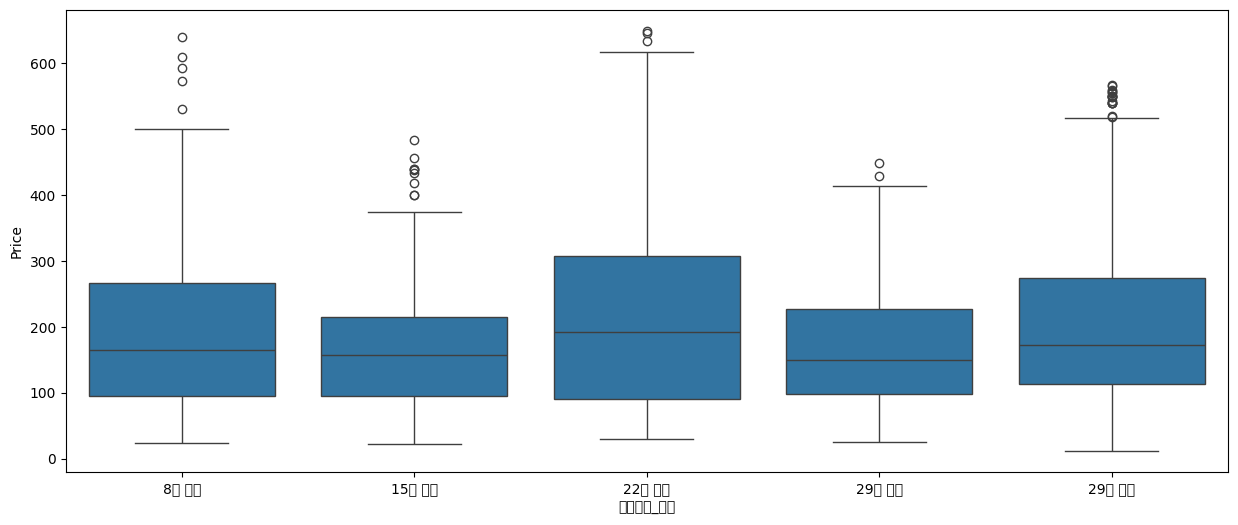

In [40]:
plt.figure(figsize=(15,6))
sns.boxplot(data=reorder_customer_cleaned, x='구매주기_구간', y='Price')

이상치를 제거한 데이터에서  
재구매 고객 중 Price 값이 가장 높게 구간인 22일 미만을 추후 활용할 예정

In [41]:
re_df = reorder_customer_cleaned.groupby(['구매주기_구간'], as_index=False)[['Customer_unique_id']].count()

re_df

,구매주기_구간,Customer_unique_id
0,8일 미만,168
1,15일 미만,121
2,22일 미만,98
3,29일 미만,69
4,29일 이상,1189


In [42]:
# 구매주기_구간이 22일 미만인 컬럼의 customer_unique_id 수와 sample_df 의 customer_unique_id 수의 합
temp_sum = re_df[re_df.구매주기_구간=="22일 미만"]["Customer_unique_id"]+sample_df["Customer_unique_id"].count()

temp_sum

2    8335
Name: Customer_unique_id, dtype: int64

In [43]:
# 위에서 구한 temp_sum 을 구매주기_구간이 22일 미만인 컬럼의 customer_unique_id 에 넣는 과정
re_df.loc[(re_df.구매주기_구간=="22일 미만"),"Customer_unique_id" ] = temp_sum

In [44]:
# 이상치를 처리한 reorder_customer_cleaned 데이터프레임에 있어서 구매주기_구간으로 묶는 과정
re_df2 = reorder_customer_cleaned.groupby(['구매주기_구간'], as_index=False)[['구매일수', 'Freight_value', 'Price']].sum()
re_df2

,구매주기_구간,구매일수,Freight_value,Price
0,8일 미만,339,6802.70,33321.30
1,15일 미만,246,4586.15,21130.22
2,22일 미만,208,3970.79,21561.39
3,29일 미만,142,2517.16,12077.97
4,29일 이상,2480,49444.44,239965.81


In [45]:
# sample_df
sample_df_order_date_count_sum = sample_df['구매일수'].sum()
sample_df_Freight_value_sum = sample_df['Freight_value'].sum()
sample_df_Price_sum = sample_df['Price'].sum()
print(sample_df_order_date_count_sum, sample_df_Freight_value_sum, sample_df_Price_sum)

8237 169955.68000000002 1085658.3299999998


In [46]:
tempsum = re_df[re_df.구매주기_구간=="22일 미만"]["Customer_unique_id"]+sample_df["Customer_unique_id"].count()

In [47]:
# 이전에 정의한 재구매 경험이 없는 고객 중 10% 랜덤 추출과 통합
# 재구매 하지 않은 일부 고객을 매출이 좋았던 구매주기 구간인 22일 미만 으로 임의로 포함시킨다
re_df2.loc[(re_df.구매주기_구간=="22일 미만"),"구매일수"] = re_df2[re_df2.구매주기_구간=="22일 미만"]["구매일수"]+sample_df_order_date_count_sum
re_df2.loc[(re_df.구매주기_구간=="22일 미만"),"Freight_value"] = re_df2[re_df2.구매주기_구간=="22일 미만"]["Freight_value"]+sample_df_Freight_value_sum
re_df2.loc[(re_df.구매주기_구간=="22일 미만"),"Price"] = re_df2[re_df2.구매주기_구간=="22일 미만"]["Price"]+sample_df_Price_sum

In [48]:
re_df

,구매주기_구간,Customer_unique_id
0,8일 미만,168
1,15일 미만,121
2,22일 미만,8335
3,29일 미만,69
4,29일 이상,1189


In [49]:
re_df2

,구매주기_구간,구매일수,Freight_value,Price
0,8일 미만,339,6802.70,33321.30
1,15일 미만,246,4586.15,21130.22
2,22일 미만,8445,173926.47,1107219.72
3,29일 미만,142,2517.16,12077.97
4,29일 이상,2480,49444.44,239965.81


In [50]:
# 데이터 병합
re_df3 = pd.merge(re_df, re_df2, on='구매주기_구간', how='inner')
re_df3

,구매주기_구간,Customer_unique_id,구매일수,Freight_value,Price
0,8일 미만,168,339,6802.70,33321.30
1,15일 미만,121,246,4586.15,21130.22
2,22일 미만,8335,8445,173926.47,1107219.72
3,29일 미만,69,142,2517.16,12077.97
4,29일 이상,1189,2480,49444.44,239965.81


In [51]:
# re_df3 에 필요한 데이터 추가
re_df3['Payment_value'] = re_df3['Freight_value'] + re_df3['Price']
re_df3['구매당순이익'] = round(re_df3['Price'] / re_df3['구매일수'], 2)
re_df3['구매당운송비'] = round(re_df3['Freight_value'] / re_df3['구매일수'], 2)
re_df3['고객당순이익'] = round(re_df3['Price'] / re_df3['Customer_unique_id'], 0)
re_df3['고객당구매수'] = round(re_df3['구매일수'] / re_df3['Customer_unique_id'], 2)
re_df3['고객당매출액'] = round(re_df3['Payment_value'] / re_df3['Customer_unique_id'], 0)

/tmp/ipykernel_368/1575356100.py:24: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_368/1575356100.py:24: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_368/1575356100.py:24: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_368/1575356100.py:24: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_368/1575356100.py:24: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_368/1575356100.py:24: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_368/1575356100.py:24: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_368/1575356100.py:24: UserWarning: Gl

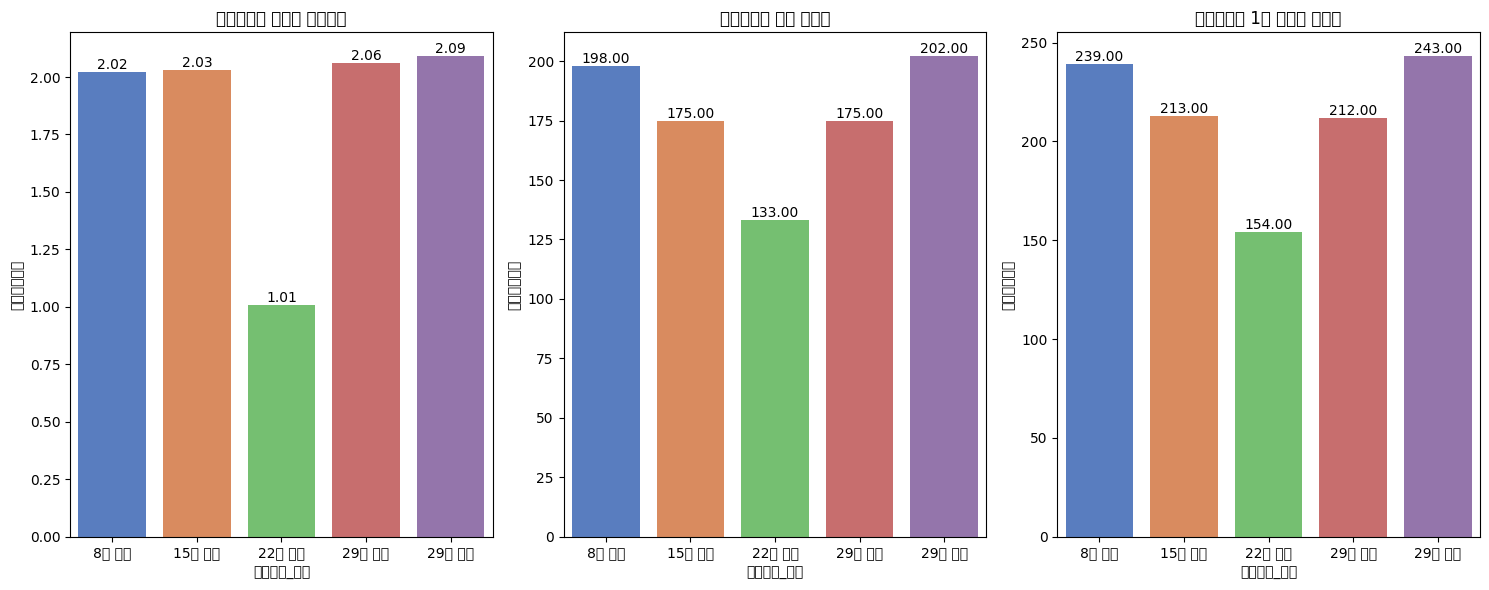

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(15,6))

# 고객당 구매 수를 보는 그래프
plt.subplot(1, 3, 1)
sns.barplot(x='구매주기_구간', y='고객당구매수', data=re_df3, palette='muted')
plt.title('구매주기별 고객당 구매횟수')
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# 고객당 순이익(price)을 보는 그래프
plt.subplot(1, 3, 2)
sns.barplot(x='구매주기_구간', y='고객당순이익', data=re_df3, palette='muted')
plt.title('구매주기별 인당 순수익')
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# 고객당 매출액(Freight_value)를 보는 그래프
plt.subplot(1, 3, 3)
sns.barplot(x='구매주기_구간', y='고객당매출액', data=re_df3, palette='muted')
plt.title('구매주기별 1회 구매당 매출액')
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [55]:
# sample_df를 합한 이후에 구매주기_구간 이 22일 미만 의 데이터 값이 성장한 것 확인
re_df3.sort_values(by='고객당순이익', ascending=False)

,구매주기_구간,Customer_unique_id,구매일수,Freight_value,Price,Payment_value,구매당순이익,구매당운송비,고객당순이익,고객당구매수,고객당매출액
4,29일 이상,1189,2480,49444.44,239965.81,289410.25,96.76,19.94,202.0,2.09,243.0
0,8일 미만,168,339,6802.70,33321.30,40124.00,98.29,20.07,198.0,2.02,239.0
1,15일 미만,121,246,4586.15,21130.22,25716.37,85.90,18.64,175.0,2.03,213.0
3,29일 미만,69,142,2517.16,12077.97,14595.13,85.06,17.73,175.0,2.06,212.0
2,22일 미만,8335,8445,173926.47,1107219.72,1281146.19,131.11,20.60,133.0,1.01,154.0


In [54]:
# re_df3 의 컬럼별 상관관계 확인
re_df3.corr(numeric_only=True).style.background_gradient(cmap='coolwarm', axis=None)

,Customer_unique_id,구매일수,Freight_value,Price,Payment_value,구매당순이익,구매당운송비,고객당순이익,고객당구매수,고객당매출액
Customer_unique_id,1.000000,0.989221,0.990398,0.997371,0.996685,0.961635,0.627096,-0.838846,-0.983749,-0.870824
구매일수,0.989221,1.000000,0.999964,0.997226,0.997850,0.959245,0.676456,-0.765844,-0.947330,-0.803223
Freight_value,0.990398,0.999964,1.000000,0.997811,0.998361,0.960443,0.675227,-0.769794,-0.949978,-0.806958
Price,0.997371,0.997226,0.997811,1.000000,0.999960,0.963593,0.654253,-0.804329,-0.968420,-0.839148
Payment_value,0.996685,0.997850,0.998361,0.999960,1.000000,0.963414,0.657249,-0.799876,-0.966180,-0.835021
구매당순이익,0.961635,0.959245,0.960443,0.963593,0.963414,1.000000,0.794919,-0.695728,-0.943064,-0.738057
구매당운송비,0.627096,0.676456,0.675227,0.654253,0.657249,0.794919,1.000000,-0.157728,-0.570563,-0.212162
고객당순이익,-0.838846,-0.765844,-0.769794,-0.804329,-0.799876,-0.695728,-0.157728,1.000000,0.894713,0.998022
고객당구매수,-0.983749,-0.947330,-0.949978,-0.968420,-0.966180,-0.943064,-0.570563,0.894713,1.000000,0.919827
고객당매출액,-0.870824,-0.803223,-0.806958,-0.839148,-0.835021,-0.738057,-0.212162,0.998022,0.919827,1.000000


In [56]:
# 구매주기_구간 인코딩
dummy_df = pd.get_dummies(re_df3['구매주기_구간'], prefix='구매주기_구간')

In [58]:
# 데이터 병합
merged_df = pd.concat([re_df3, dummy_df], axis=1)

merged_df

,구매주기_구간,Customer_unique_id,구매일수,Freight_value,Price,Payment_value,구매당순이익,구매당운송비,고객당순이익,고객당구매수,고객당매출액,구매주기_구간_8일 미만,구매주기_구간_15일 미만,구매주기_구간_22일 미만,구매주기_구간_29일 미만,구매주기_구간_29일 이상
0,8일 미만,168,339,6802.70,33321.30,40124.00,98.29,20.07,198.0,2.02,239.0,True,False,False,False,False
1,15일 미만,121,246,4586.15,21130.22,25716.37,85.90,18.64,175.0,2.03,213.0,False,True,False,False,False
2,22일 미만,8335,8445,173926.47,1107219.72,1281146.19,131.11,20.60,133.0,1.01,154.0,False,False,True,False,False
3,29일 미만,69,142,2517.16,12077.97,14595.13,85.06,17.73,175.0,2.06,212.0,False,False,False,True,False
4,29일 이상,1189,2480,49444.44,239965.81,289410.25,96.76,19.94,202.0,2.09,243.0,False,False,False,False,True


In [59]:
merged_drop_df = merged_df.drop(["구매주기_구간"],axis=1)

In [61]:
# merged_drop_df 의 컬럼별 상관관계 확인
correlation_matrix = merged_drop_df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm', axis=None)

correlation_matrix

,Customer_unique_id,구매일수,Freight_value,Price,Payment_value,구매당순이익,구매당운송비,고객당순이익,고객당구매수,고객당매출액,구매주기_구간_8일 미만,구매주기_구간_15일 미만,구매주기_구간_22일 미만,구매주기_구간_29일 미만,구매주기_구간_29일 이상
Customer_unique_id,1.000000,0.989221,0.990398,0.997371,0.996685,0.961635,0.627096,-0.838846,-0.983749,-0.870824,-0.282005,-0.289334,0.991570,-0.297443,-0.122788
구매일수,0.989221,1.000000,0.999964,0.997226,0.997850,0.959245,0.676456,-0.765844,-0.947330,-0.803223,-0.313274,-0.327904,0.961908,-0.344264,0.023534
Freight_value,0.990398,0.999964,1.000000,0.997811,0.998361,0.960443,0.675227,-0.769794,-0.949978,-0.806958,-0.309911,-0.326808,0.964137,-0.342581,0.015163
Price,0.997371,0.997226,0.997811,1.000000,0.999960,0.963593,0.654253,-0.804329,-0.968420,-0.839148,-0.296343,-0.310827,0.979576,-0.321582,-0.050824
Payment_value,0.996685,0.997850,0.998361,0.999960,1.000000,0.963414,0.657249,-0.799876,-0.966180,-0.835021,-0.298248,-0.313062,0.977744,-0.324496,-0.041937
구매당순이익,0.961635,0.959245,0.960443,0.963593,0.963414,1.000000,0.794919,-0.695728,-0.943064,-0.738057,-0.033865,-0.403875,0.946257,-0.428960,-0.079557
구매당운송비,0.627096,0.676456,0.675227,0.654253,0.657249,0.794919,1.000000,-0.157728,-0.570563,-0.212162,0.319955,-0.358881,0.571552,-0.790868,0.258243
고객당순이익,-0.838846,-0.765844,-0.769794,-0.804329,-0.799876,-0.695728,-0.157728,1.000000,0.894713,0.998022,0.436157,-0.032610,-0.888620,-0.032610,0.517682
고객당구매수,-0.983749,-0.947330,-0.949978,-0.968420,-0.966180,-0.943064,-0.570563,0.894713,1.000000,0.919827,0.213572,0.225571,-0.998271,0.261566,0.297562
고객당매출액,-0.870824,-0.803223,-0.806958,-0.839148,-0.835021,-0.738057,-0.212162,0.998022,0.919827,1.000000,0.421442,0.012580,-0.915221,-0.003145,0.484344


In [74]:
# 기존 데이터 reorder_customer_cleaned
# Payment_value 컬럼 추가
reorder_customer_cleaned['Payment_value'] = reorder_customer_cleaned['Price'] + reorder_customer_cleaned['Freight_value']

reorder_customer_cleaned

,Customer_unique_id,구매일수,first_order_timestamp,latest_order_timestamp,재구매여부,구매간격,구매주기,Price,Freight_value,구매주기_구간,Payment_value
0,CUSTOMER_Unique_00494,2,2019-04-18 10:46:28,2019-04-25 09:00:27,Y,6,6.0,390.00,54.59,8일 미만,444.59
1,CUSTOMER_Unique_00590,2,2019-01-16 10:18:45,2019-01-23 14:50:49,Y,7,7.0,166.98,60.05,8일 미만,227.03
2,CUSTOMER_Unique_01181,2,2018-11-19 20:35:05,2018-11-24 01:39:47,Y,4,4.0,493.24,21.88,8일 미만,515.12
3,CUSTOMER_Unique_01188,2,2018-10-26 22:29:48,2018-11-01 16:00:04,Y,5,5.0,78.00,30.20,8일 미만,108.20
4,CUSTOMER_Unique_01223,2,2018-11-24 17:38:56,2018-11-25 00:16:56,Y,0,0.0,63.80,31.21,8일 미만,95.01
...,...,...,...,...,...,...,...,...,...,...,...
1640,CUSTOMER_Unique_79821,2,2018-01-26 21:58:21,2018-12-03 22:53:14,Y,311,311.0,278.90,39.52,29일 이상,318.42
1641,CUSTOMER_Unique_81626,2,2018-06-06 17:00:18,2019-04-26 18:07:40,Y,324,324.0,199.60,23.26,29일 이상,222.86
1642,CUSTOMER_Unique_82027,2,2018-12-30 00:06:41,2019-04-29 22:59:41,Y,120,120.0,163.90,22.90,29일 이상,186.80
1643,CUSTOMER_Unique_82450,2,2018-04-24 10:53:12,2019-01-19 08:02:06,Y,269,269.0,93.50,25.11,29일 이상,118.61


In [76]:
# 구매주기_기간이 22일 미만인 데이터만 따로 추출
under_22 = reorder_customer_cleaned.loc[reorder_customer_cleaned['구매주기_구간']=='22일 미만']

under_22

,Customer_unique_id,구매일수,first_order_timestamp,latest_order_timestamp,재구매여부,구매간격,구매주기,Price,Freight_value,구매주기_구간,Payment_value
289,CUSTOMER_Unique_00200,2,2019-01-16 11:04:42,2019-02-01 19:34:28,Y,16,16.0,119.80,20.75,22일 미만,140.55
290,CUSTOMER_Unique_00492,2,2019-01-04 12:02:33,2019-01-23 10:54:12,Y,18,18.0,362.00,42.27,22일 미만,404.27
291,CUSTOMER_Unique_01211,2,2018-09-11 14:20:12,2018-09-27 16:56:27,Y,16,16.0,219.70,53.55,22일 미만,273.25
292,CUSTOMER_Unique_01269,2,2019-04-04 16:20:32,2019-04-24 21:07:06,Y,20,20.0,71.80,30.46,22일 미만,102.26
293,CUSTOMER_Unique_01477,2,2019-05-04 16:32:18,2019-05-26 07:48:45,Y,21,21.0,267.00,35.72,22일 미만,302.72
...,...,...,...,...,...,...,...,...,...,...,...
382,CUSTOMER_Unique_65625,2,2019-03-06 11:20:35,2019-03-24 09:43:16,Y,17,17.0,49.98,15.79,22일 미만,65.77
383,CUSTOMER_Unique_68509,2,2019-05-30 16:57:26,2019-06-16 11:58:28,Y,16,16.0,193.50,50.39,22일 미만,243.89
384,CUSTOMER_Unique_73845,2,2018-04-25 15:14:44,2018-05-17 14:07:47,Y,21,21.0,325.40,62.14,22일 미만,387.54
385,CUSTOMER_Unique_77536,2,2018-11-13 23:55:37,2018-11-29 08:37:46,Y,15,15.0,72.80,26.95,22일 미만,99.75


In [78]:
# 기존 22일 미만 Payment_value : 25532.179999999997
under_22.Payment_value.sum()

25532.179999999997

In [66]:
# sample_df 추가한 22일 미만 Payment_value : 1281146.19
merged_df.loc[merged_df['구매주기_구간']=='22일 미만']

,구매주기_구간,Customer_unique_id,구매일수,Freight_value,Price,Payment_value,구매당순이익,구매당운송비,고객당순이익,고객당구매수,고객당매출액,구매주기_구간_8일 미만,구매주기_구간_15일 미만,구매주기_구간_22일 미만,구매주기_구간_29일 미만,구매주기_구간_29일 이상
2,22일 미만,8335,8445,173926.47,1107219.72,1281146.19,131.11,20.6,133.0,1.01,154.0,False,False,True,False,False


재구매를 하지 않은 소비자 중 임의의 10% 를 22일 미만 내에 재구매 하도록 유도했다면 매출액이 25532.179999999997 에서 1281146.19 로 증가 했을 것

### KPI 2
마지막 구매 이후 22일이 지나기 전에 재구매를 할 수 있도록 유도하자